# 0.0. Solution Planning ( IOT )

## Input

### Business Problem

1. Assist the development of artisanal market with produces independently cakes and sweet
2. In which brazilian cities Moça should start a incentive program of gastronomic artisanal entrepreneurship
3. The proposal must consider the sustainability and scalability of the business.

## Output

1. Introduce a parameter of artisanal producers of cake and sweet status
2. Introduce which parameter it should be considered to choose a city to hold the incentive program.
3. Indicate in termos of revenue what could be the potential of chosen place and why it is important.

## Tasks

1. **Introduce a parameter of artisanal producers of cake and sweet status.**
    * What is the context of artisanal market of cake and sweet in Brazil?
        - How this market is composed (sex, age, region)
        - What are the main markets
        - What are the potential  of each region
        - Is there a great volume of street small stores selling "homemade cakes". What is the potential of this suppliers signing in for "Vem de Bolo" platform?
        - People which sells from internet (facebook, whatsapp, instagram), what is the potential of this market?
        - What is the main trouble in this market? An online platform ("Vem de bolo") could help this producers sell more?
        - What is the best way to reach this public in terms of communication?
            
            
2. **Introduce which parameter it should be considered to choose a city to hold the incentive program.**
    * What are the key factors "Vem de Bolo" could teach us?
         - **Learning from Suplier Database**
            - What is the average revenue by suplier?
            - How this supliers are distributed? (city and location)
            - Which attributes is important for this supplier be elected to "Vem de Bolo" platform?
            - What is the main method of delivery?
         - **Learning from Customer Database**
            - What is the purchase profile of customers?
            - How much do they spend in average?
            - Which product the customers purchase at most? Is it related to the bias of disponibility?
            - What does make a customer choose a specific suplier? Is rating important?    
    
3. **3. Indicate in termos of revenue what could be the potential of chosen place and why it is important.**
    * Between social-economic factors, what make a city be chosen for "Vem de Bolo" platform?
        - What is potential of earning for city elected for this program?
        - Is there scability where we could improve the earning without taking huge losses? (Taking a big city and them expanding to smallers and closest ones)
        - What should be the costs Moça should support to make this expansion (marketing, business, IT, etc.)?

# 0.0. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import inflection

from unidecode import unidecode

from scipy import stats as ss
from statsmodels.stats.diagnostic import lilliefors
from sklearn import preprocessing as pp
from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import mixture as mx

from plotly import express as px

from matplotlib import pyplot as plt
from IPython.core.display import HTML

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

def describe_num(num_attributes):
    a = num_attributes.describe().T.reset_index()
    
    d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T      
    d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(num_attributes.apply( lambda x: x.unique().shape[0])).T
    
    n = pd.concat([d4, d5, d6, d7], axis=0).T.reset_index()
    n.columns = ['attibutes', 'range', 'skew', 'kurtosis', 'unique']
    b = a.merge(n, right_on='attibutes', left_on='index')
    b.drop('index', axis=1, inplace=True)
    columns = ['attibutes', 'count', 'mean', 'std', '25%', '50%', '75%', 'min', 'max', 'range',
           'skew', 'kurtosis', 'unique']
    return b[columns]

def normal_test(normality_test):
    alpha = 0.05

    sf_t, k2_t, and_t, q2_t, lf_t, jb_t, ks_t = [[], [], [], [], [], [], []]
    name_columns = normality_test.columns

    for i in normality_test:
        if len(normality_test[i])<50:
            # Shapiro-Wilk Test - SAMPLE < 50
            statistic_wb, pvalue_wb = ss.shapiro(normality_test[i])        
            if pvalue_wb > alpha:
                sf_t = sf_t + ["Yes"]
            else:
                sf_t = sf_t + ["No"]
        else:
            sf_t = sf_t + ['Test not possible']

        # D’Agostino’s K-squared test
        k2, p_k2 = ss.normaltest(normality_test[i])
        if p_k2 > alpha:
            k2_t = k2_t + ["Yes"]
        else:
            k2_t = k2_t + ["No"]

        # Anderson-Darling Normality Test
        and_test = ss.anderson(normality_test[i], dist='norm')
        if and_test.statistic < and_test.critical_values[2]: #alpha = 0.05
            and_t = and_t + ["Yes"]
        else:
            and_t = and_t + ["No"]

        # Chi-Square Normality Test
        statistic_q2, pvalue_q2 = ss.chisquare(normality_test[i])
        if pvalue_q2 > alpha:
            q2_t = q2_t + ["Yes"]
        else:
            q2_t = q2_t + ["No"]

        # Lilliefors Test for Normality
        statistic_lillie, pvalue_lillie = lilliefors(normality_test[i])
        if pvalue_lillie > alpha:
            lf_t = lf_t + ["Yes"]
        else:
            lf_t = lf_t + ["No"]

        #Jarque–Bera test for Normality (SAMPLES > 2000)
        if len(normality_test[i]) > 2000:
            statistic_jb, pvalue_jb = ss.jarque_bera(normality_test[i])
            alpha = 0.05
            if pvalue_jb > alpha:
                jb_t = jb_t + ["Yes"]
            else:
                jb_t = jb_t + ["No"]
        else:
            jb_t = jb_t + ['Test not possible']

        # Kolmogorov-Smirnov test for Normality
        statistic_ks, pvalue_ks = ss.kstest(normality_test[i], 'norm')
        if pvalue_ks > alpha:
            ks_t = ks_t + ["Yes"]
        else:
            ks_t = ks_t + ["No"]

    normal_t = pd.DataFrame([sf_t, k2_t, and_t, q2_t, lf_t, jb_t, ks_t], columns=name_columns).T
    normal_t.columns = ['Shapiro-Wilk Test', 'D’Agostino’s K-squared',
                    'Anderson-Darling', 'Chi-Square',
                    'Lilliefors', 'Jarque–Bera', 'Kolmogorov-Smirnov']
    
    return normal_t

pd.options.display.float_format = '{:.2f}'.format

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [3]:
df_solds_cognatis = pd.read_csv('../data/raw/tb_solds_cognatis.csv', delimiter=';')
df_solds_cognatis['UF'] = df_solds_cognatis['UF'].apply(lambda x: str.lower(x) if isinstance(x, str) else x)
df_solds_cognatis['MUNICIPIO'] = df_solds_cognatis['MUNICIPIO'].apply(lambda x: str.lower(x) if isinstance(x, str) else x)
df_solds_cognatis['MUNICIPIO.UF'] = df_solds_cognatis['UF'] + ' / '+ df_solds_cognatis['MUNICIPIO']

In [4]:
df_solds_cognatis.head()

SETOR_ATIV   UF         MUNICIPIO         CEP  TRABALHADORES  S_RENDA_MEDIA  S_FLUXO_PEDESTRE  S_FLUXO_VEICULOS  S_POP_TOTAL  S_DOM_PART_PERM  S_PCT_CRIANCAS  S_PCT_ADOLESCENTE  S_PCT_JOVENS  S_PCT_ADULTOS  S_PCT_SENIOR  S_PCT_IDOSOS  S_RENDA_MEDIA_FAMILIAR  S_DENSIDADE_POPULACAO_KM2  S_PCT_CLASSE_A  S_PCT_CLASSE_B  S_PCT_CLASSE_C  S_PCT_CLASSE_D  S_PCT_CLASSE_E  S_TX_CRESC_POP  S_TX_CRESC_DOM  S_TX_CRESC_RENDA_MEDIA  S_RENDA_PER_CAPITA  S_COMERCIALIZACAO  S_QTD_EMPRESAS  S_PCT_CNAE_AGRICOLA  S_PCT_CNAE_COMERCIO  S_PCT_CNAE_CONSTR_CIVIL  S_PCT_CNAE_INDUSTRIA  S_PCT_CNAE_SERVICOS  S_PCT_CNAE_OUTROS  S_SEM_FUNC  S_DE_1_4_FUNC  S_DE_5_9_FUNC  S_DE_10_19_FUNC  S_DE_20_49_FUNC  S_DE_50_99_FUNC  S_DE_100_249_FUNC  S_DE_250_499_FUNC  S_DE_500_999_FUNC  S_MAIS1000_FUNC  S_SUPERMERCADO  S_TT_PADARIA  S_ATACADO  S_HIPERMERCADO  S_MINIMERCADO           MUNICIPIO.UF
0        NaN  NaN               NaN         nan       18776.60        1852.33              3.16              4.93     61660.28         22297.53           12.02              13.21         15.78          31.95         17.22          9.82                 5372.33                    5057.62            5.61           31.25           40.72           19.33            3.10            1.70            3.41                    1.35             2028.93              14.77         7202.39                 0.81                32.40                     6.79                  8.03                51.08               0.50     4817.48         708.80         244.79           135.84            79.59            22.88              12.44               4.03               2.00             1.67            8.77         57.61      23.13            2.87          85.97                    NaN
1        NaN   ac        rio branco 69900001.00       13125.00        3502.67              4.00              6.00     53376.00         17146.00           15.95              17.56         18.25          30.02         12.17          6.05                 2121.07                    4036.81            0.61           10.16           39.75           40.52            8.96            1.44            3.03                    0.73              684.11               9.48         3624.00                 0.61                45.23                     4.75                  7.01                40.59               1.82     2757.00         324.00         101.00            71.00            42.00            15.00              15.00               3.00               4.00             2.00            3.00         22.00       3.00            9.00         184.00        ac / rio branco
2        NaN   ac        rio branco 69900001.00       18364.00        2477.16              4.00              6.00     73460.00         24698.00           12.57              15.06         17.82          32.40         15.48          6.68                 4266.92                    6317.30            4.44           27.27           40.43           24.36            3.49            1.34            3.10                    0.78             1438.17              12.00         4795.00                 0.31                42.17                     6.07                  5.51                44.67               1.27     3295.00         540.00         190.00           131.00            65.00            19.00              19.00               6.00               2.00             2.00           14.00         29.00      27.00            9.00         111.00        ac / rio branco
3        NaN   ac    sena madureira         nan         960.00        1225.87              0.00              0.00     26675.50          7823.50           14.16              20.74         21.14          29.10          9.55          5.30                 1917.38                      46.92            0.19            7.22           26.47           37.23           28.89            3.51            5.27                    1.84              564.92               7.15          951.50                 0.71                55.98       

### 0.2.1 Analysis CEP
Conclusion
- Considering CEP were misinputted, we are going to use the cities and states available in the DB.
- Whole CEP feature will be eliminated.

In [5]:
## Ajustando os CEP por Municipio
#aux = pd.DataFrame(df_solds_cognatis['MUNICIPIO.UF'].unique().tolist())
#aux = aux.rename(columns={0: 'MUNICIPIO.UF'})
#df_solds_cognatis_na = df_solds_cognatis.dropna()
#mun_cep = df_solds_cognatis_na[['MUNICIPIO.UF', 'CEP']].drop_duplicates(subset='MUNICIPIO.UF')
#total = pd.merge(aux, mun_cep, how='left', on='MUNICIPIO.UF')

In [6]:
# Base de dados com os CEP do Brasil
df_cep_br = pd.read_csv('../data/cep_brasil/ceps.csv')
df_cep_br = df_cep_br.rename(columns={'CIDADE': 'MUNICIPIO', 'CEP DE': 'cep_de', 'CEP ATÉ': 'cep_ate'})
df_cep_br['MUNICIPIO'] = df_cep_br['MUNICIPIO'].apply(lambda x: str.lower(x) if isinstance(x, str) else x)
df_cep_br['UF'] = df_cep_br['UF'].apply(lambda x: str.lower(x) if isinstance(x, str) else x)
df_cep_br['MUNICIPIO'] = df_cep_br['MUNICIPIO'].apply(lambda x: unidecode(x) if isinstance(x, str) else x)
df_cep_br['MUNICIPIO.UF'] = df_cep_br['UF'] + ' / '+ df_cep_br['MUNICIPIO']
df_cep_br_ = df_cep_br.copy()
df_cep_br_ = df_cep_br_.dropna()
df_cep_br_ = df_cep_br_[['MUNICIPIO.UF', 'cep_de']]
df_cep_br_ = df_cep_br_.drop_duplicates(subset='MUNICIPIO.UF')

# Juntando os dataframes para verificação dos CEP
df_solds_cognatis_ = df_solds_cognatis.merge(df_cep_br_, how='left', on='MUNICIPIO.UF')

In [7]:
df_cep_br[df_cep_br['MUNICIPIO'] == 'gama']

Empty DataFrame
Columns: [UF, MUNICIPIO, cep_de, cep_ate, MUNICIPIO.UF]
Index: []

In [8]:
df_cep_br[df_cep_br['MUNICIPIO.UF'] == 'sp / sao paulo']

UF  MUNICIPIO   cep_de  cep_ate    MUNICIPIO.UF
5566  sp  sao paulo  1000001  5999999  sp / sao paulo
5567  sp  sao paulo  8000000  8499999  sp / sao paulo

In [9]:
df_solds_cognatis_['CEP_'] = df_solds_cognatis_['CEP'] + 1
df_solds_cognatis_['verificacao_1'] = df_solds_cognatis_.apply(lambda x: 1 if x['CEP'] == x['cep_de'] else 0, axis=1)
df_solds_cognatis_['verificacao_2'] = df_solds_cognatis_.apply(lambda x: 1 if x['CEP_'] == x['cep_de'] else 0, axis=1)

In [10]:
df_solds_cognatis_[(df_solds_cognatis_['verificacao_1'] == 0)
                   & (df_solds_cognatis_['verificacao_2'] == 0) 
                   & ~(df_solds_cognatis_['CEP'].isna())
                   & ~(df_solds_cognatis_['MUNICIPIO'] == 'brasilia')
                   #& (df_solds_cognatis_['MUNICIPIO'] == 'sao paulo')
                  ].head(40)

SETOR_ATIV  UF                MUNICIPIO         CEP  TRABALHADORES  S_RENDA_MEDIA  S_FLUXO_PEDESTRE  S_FLUXO_VEICULOS  S_POP_TOTAL  S_DOM_PART_PERM  S_PCT_CRIANCAS  S_PCT_ADOLESCENTE  S_PCT_JOVENS  S_PCT_ADULTOS  S_PCT_SENIOR  S_PCT_IDOSOS  S_RENDA_MEDIA_FAMILIAR  S_DENSIDADE_POPULACAO_KM2  S_PCT_CLASSE_A  S_PCT_CLASSE_B  S_PCT_CLASSE_C  S_PCT_CLASSE_D  S_PCT_CLASSE_E  S_TX_CRESC_POP  S_TX_CRESC_DOM  S_TX_CRESC_RENDA_MEDIA  S_RENDA_PER_CAPITA  S_COMERCIALIZACAO  S_QTD_EMPRESAS  S_PCT_CNAE_AGRICOLA  S_PCT_CNAE_COMERCIO  S_PCT_CNAE_CONSTR_CIVIL  S_PCT_CNAE_INDUSTRIA  S_PCT_CNAE_SERVICOS  S_PCT_CNAE_OUTROS  S_SEM_FUNC  S_DE_1_4_FUNC  S_DE_5_9_FUNC  S_DE_10_19_FUNC  S_DE_20_49_FUNC  S_DE_50_99_FUNC  S_DE_100_249_FUNC  S_DE_250_499_FUNC  S_DE_500_999_FUNC  S_MAIS1000_FUNC  S_SUPERMERCADO  S_TT_PADARIA  S_ATACADO  S_HIPERMERCADO  S_MINIMERCADO                  MUNICIPIO.UF      cep_de        CEP_  verificacao_1  verificacao_2
1216        NaN  ce        juazeiro do norte 63970000.00        1285.00        3246.02              2.00              5.00     14759.00          4393.00           17.40              16.61         19.42          32.50          9.50          4.59                 2489.00                     472.29            3.07           11.38           37.83           41.18            6.53            6.25            8.73                    0.03              761.22              11.84          598.00                 0.17                37.96                     5.69                 18.73                36.12               1.34      478.00          28.00          10.00            10.00             6.00             2.00               2.00               1.00               0.00             0.00            0.00         11.00       0.00            0.00          39.00        ce / juazeiro do norte 63000001.00 63970001.00              0              0
1405        NaN  df         distrito federal 70000001.00       13118.00        1684.55              4.00              6.00     91135.00         32165.00           11.54              12.96         15.39          34.22         17.56          8.33                 5000.22                    8198.97            1.61           42.21           47.05            8.72            0.41            0.55            2.34                    0.49             1770.93              14.16         8673.00                 0.02                36.70                     5.70                  6.83                50.46               0.30     6305.00         870.00         248.00           143.00            67.00            16.00              12.00               1.00               0.00             1.00            0.00        103.00       0.00            3.00          63.00         df / distrito federal         nan 70000002.00              0              0
1406        NaN  df                     gama 70000001.00      214634.00        3612.29              4.00              6.00     76848.00         27268.00           11.34              14.74         13.87          35.66         14.58          9.80                 5436.56                    6938.67            1.69           42.68           44.63           10.94            0.05            0.81            2.60                    1.38             1933.01               9.51         8707.00                 0.17                31.79                     6.48                  7.80                52.11               1.65     6446.00         877.00         241.00           135.00            77.00            16.00              12.00               1.00               1.00             9.00            0.00        128.00       0.00            3.00          91.00                     df / gama         nan 70000002.00              0              0
1407        NaN  df               sobradinho 73000001.00           0.00           0.00              1.00              4.00       762.00           237.00           15.88              15.75         13.52          28.48         14.97         11.42     

In [11]:
df_solds_cognatis_[df_solds_cognatis_['MUNICIPIO'].str.contains('santa do paraiso', case=False, na=False)]

SETOR_ATIV  UF         MUNICIPIO  CEP  TRABALHADORES  S_RENDA_MEDIA  S_FLUXO_PEDESTRE  S_FLUXO_VEICULOS  S_POP_TOTAL  S_DOM_PART_PERM  S_PCT_CRIANCAS  S_PCT_ADOLESCENTE  S_PCT_JOVENS  S_PCT_ADULTOS  S_PCT_SENIOR  S_PCT_IDOSOS  S_RENDA_MEDIA_FAMILIAR  S_DENSIDADE_POPULACAO_KM2  S_PCT_CLASSE_A  S_PCT_CLASSE_B  S_PCT_CLASSE_C  S_PCT_CLASSE_D  S_PCT_CLASSE_E  S_TX_CRESC_POP  S_TX_CRESC_DOM  S_TX_CRESC_RENDA_MEDIA  S_RENDA_PER_CAPITA  S_COMERCIALIZACAO  S_QTD_EMPRESAS  S_PCT_CNAE_AGRICOLA  S_PCT_CNAE_COMERCIO  S_PCT_CNAE_CONSTR_CIVIL  S_PCT_CNAE_INDUSTRIA  S_PCT_CNAE_SERVICOS  S_PCT_CNAE_OUTROS  S_SEM_FUNC  S_DE_1_4_FUNC  S_DE_5_9_FUNC  S_DE_10_19_FUNC  S_DE_20_49_FUNC  S_DE_50_99_FUNC  S_DE_100_249_FUNC  S_DE_250_499_FUNC  S_DE_500_999_FUNC  S_MAIS1000_FUNC  S_SUPERMERCADO  S_TT_PADARIA  S_ATACADO  S_HIPERMERCADO  S_MINIMERCADO           MUNICIPIO.UF  cep_de  CEP_  verificacao_1  verificacao_2
1821        NaN  mg  santa do paraiso  nan         970.00        1279.65              2.00              5.00      9567.00          3131.00           16.36              13.41         16.99          32.60         13.67          6.97                 3176.23                     108.92            1.02           26.41           42.67           28.68            1.21            5.79            7.27                    4.74             1071.87              11.05          795.00                 0.13                25.91                     8.68                 11.19                53.96               0.13      573.00          50.00          16.00            17.00            13.00             2.00               0.00               0.00               0.00             0.00            0.00          5.00       0.00            0.00           8.00  mg / santa do paraiso     nan   nan              0              0

In [12]:
df_cep_br.shape

(5794, 5)

### 0.2.3 DB MUNICIPALITY POPULATION (External Data from IBGE)

In [13]:
df_municipios = pd.read_excel('../data/external/POP2020_20210331.xls', sheet_name='Municípios', header=1, skipfooter=23)
df_municipios = df_municipios.drop(columns=['COD. UF', 'COD. MUNIC'])
df_municipios['NOME DO MUNICÍPIO'] = df_municipios['NOME DO MUNICÍPIO'].apply(lambda x: str.lower(x))
df_municipios['UF'] = df_municipios['UF'].apply(lambda x: str.lower(x))
df_municipios['NOME DO MUNICÍPIO'] = df_municipios['NOME DO MUNICÍPIO'].apply(lambda x: unidecode(x))
df_municipios['MUNICIPIO.UF'] = df_municipios['UF'] + ' / ' + df_municipios['NOME DO MUNICÍPIO']
df_municipios = df_municipios.rename(columns={'POPULAÇÃO ESTIMADA': 'POP_ESTIMADA'})
df_municipios = df_municipios[['MUNICIPIO.UF', 'POP_ESTIMADA']]

In [14]:
df_solds_cognatis_ = df_solds_cognatis.merge(df_municipios, on='MUNICIPIO.UF', how='left')
df_solds_cognatis_.shape

(82391, 52)

In [15]:
df_na = df_solds_cognatis_[df_solds_cognatis_['POP_ESTIMADA'].isna()]
rm_index = df_na.index.tolist()
df_solds_cognatis_rm = df_solds_cognatis_[~df_solds_cognatis_.index.isin(rm_index)]
df_na = df_na.drop(columns=['MUNICIPIO.UF', 'POP_ESTIMADA'])
df_solds_cognatis_.shape

(82391, 52)

In [16]:
df_na.isna().sum()

SETOR_ATIV                   48
UF                            1
MUNICIPIO                     1
CEP                          38
TRABALHADORES                 0
S_RENDA_MEDIA                 0
S_FLUXO_PEDESTRE              0
S_FLUXO_VEICULOS              0
S_POP_TOTAL                   0
S_DOM_PART_PERM               0
S_PCT_CRIANCAS                0
S_PCT_ADOLESCENTE             0
S_PCT_JOVENS                  0
S_PCT_ADULTOS                 0
S_PCT_SENIOR                  0
S_PCT_IDOSOS                  0
S_RENDA_MEDIA_FAMILIAR        0
S_DENSIDADE_POPULACAO_KM2     0
S_PCT_CLASSE_A                0
S_PCT_CLASSE_B                0
S_PCT_CLASSE_C                0
S_PCT_CLASSE_D                0
S_PCT_CLASSE_E                0
S_TX_CRESC_POP                0
S_TX_CRESC_DOM                0
S_TX_CRESC_RENDA_MEDIA        0
S_RENDA_PER_CAPITA            0
S_COMERCIALIZACAO             0
S_QTD_EMPRESAS                0
S_PCT_CNAE_AGRICOLA           0
S_PCT_CNAE_COMERCIO           0
S_PCT_CN

In [17]:
map_ = {'olho d agua das flores': 'olho d\'agua das flores', 
       'olho d agua do casado': 'olho d\'agua do casado',
       'tanque d arca': 'tanque d\'arca', 
       'dias d avila': 'dias d\'avila', 
       'distrito federal': 'brasilia', 
       'gama': 'brasilia',
       'sobradinho': 'brasilia', 
       'taguatinga': 'brasilia', 
       'taguatinga norte': 'brasilia', 
       'santa do paraiso': 'santana do paraiso',
       'mirassol d oeste': 'mirassol d\'oeste', 
       'igarape miri': 'igarape-miri', 
       'santa isabel do para': 'santa izabel do para',
       'santo agostinho': 'cabo de santo agostinho', 
       'olho d agua do piaui': 'olho d\'agua do piaui', 
       'pau d arco do piaui': 'pau d\'arco do piaui',
       'itapejara d oeste': 'itapejara d\'oeste', 
       'assu': 'acu', 
       'lagoa d anta': 'lagoa d\'anta',
       'alta floresta d oeste': 'alta floresta d\'oeste', 
       'alvorada d oeste': 'alvorada d\'oeste', 
       'espigao d oeste': 'espigao d\'oeste',
       'ji parana': 'ji-parana', 
       'machadinho d oeste': 'machadinho d\'oeste', 
       'nova brasilandia d oeste': 'nova brasilandia d\'oeste',
       'santa luzia d oeste': 'santa luzia d\'oeste', 
       'santana do livramento': 'sant\'ana do livramento',
       'amparo de sao francisco': 'amparo do sao francisco', 
       'barras dos coqueiros': 'barra dos coqueiros',
       'itaporanga d ajuda': 'itaporanga d\'ajuda', 
       'biritiba-mirim': 'biritiba mirim', 
       'embu': 'embu das artes', 
       'embu guacu': 'embu-guacu',
       'santa barbara d oeste': 'santa barbara d\'oeste', 
       'saopaulo': 'sao paulo', 
       'fortaleza do tabocao': 'tabocao',
       'olho d:agua das flores': 'olho d\'agua das flores', 
       'olho d:agua do casado': 'olho d\'agua do casado',
       'olho d:agua grande': 'olho d\'agua grande', 
       'tanque d:arca': 'tanque d\'arca', 
       'dias d:avila': 'dias d\'avila',
       'muquem de sao francisco': 'muquem do sao francisco', 
       'santa teresinha': 'santa terezinha', 
       'bom jesus': 'bom jesus de goias',
       'sao joao d:alianca': 'sao joao d\'alianca', 
       'olho d:agua das cunhas': 'olho d\'agua das cunhas', 
       'pindare mirim': 'pindare-mirim',
       'amparo da serra': 'amparo do serra', 
       'barao do monte alto': 'barao de monte alto', 
       'brasopolis': 'brazopolis',
       'olhos-d:agua': 'olhos-d\'agua', 
       'pingo d:agua': 'pingo-d\'agua', 
       'conquista d:oeste': 'conquista d\'oeste',
       'figueiropolis d:oeste': 'figueiropolis d\'oeste', 
       'gloria d:oeste': 'gloria d\'oeste', 
       'lambari d:oeste': 'lambari d\'oeste',
       'mirassol d:oeste': 'mirassol d\'oeste', 
       'poxoreo': 'poxoreu', 
       'eldorado dos carajas': 'eldorado do carajas',
       'mae d:agua': 'mae d\'agua', 
       'olho d:agua': 'olho d\'agua', 
       'belem de sao francisco': 'belem do sao francisco', 
       'iguaraci': 'iguaracy',
       'lagoa do itaenga': 'lagoa de itaenga', 
       'barra d:alcantara': 'barra d\'alcantara', 
       'pau d:arco do piaui': 'pau d\'arco do piaui',
       'diamante d:oeste': 'diamante d\'oeste', 
       'itapejara d:oeste': 'itapejara d\'oeste', 
       'perola d:oeste': 'perola d\'oeste',
       'rancho alegre d:oeste': 'rancho alegre d\'oeste', 
       'sao jorge d:oeste': 'sao jorge d\'oeste', 
       'boa saude': 'januario cicco',
       'lagoa d:anta': 'lagoa d\'anta', 
       'olho d:agua do borges': 'olho d\'agua do borges', 
       'alta floresta d:oeste': 'alta floresta d\'oeste',
       'alvorada d:oeste': 'alvorada d\'oeste', 
       'espigao d:oeste': 'espigao d\'oeste', 
       'espigao doeste': 'espigao d\'oeste',
       'machadinho d:oeste': 'machadinho d\'oeste', 
       'nova brasilandia d:oeste': 'nova brasilandia d\'oeste',
       'santa luzia d:oeste': 'santa luzia d\'oeste', 
       'entre ijuis': 'entre-ijuis', 
       'balneario de picarras': 'balneario picarras',
       'herval d:oeste': 'herval d\'oeste', 
       'graccho cardoso': 'gracho cardoso', 
       'itaporanga d:ajuda': 'itaporanga d\'ajuda',
       'aparecida d:oeste': 'aparecida d\'oeste', 
       'estrela d:oeste': 'estrela d\'oeste', 
       'guarani d:oeste': 'guarani d\'oeste',
       'mogi-guacu': 'mogi guacu', 
       'palmeira d:oeste': 'palmeira d\'oeste', 
       'santa barbara d:oeste': 'santa barbara d\'oeste',
       'santa clara d:oeste': 'santa clara d\'oeste', 
       'santa rita d:oeste': 'santa rita d\'oeste',
       'sao joao do pau d:alho': 'sao joao do pau d\'alho', 
       'couto de magalhaes': 'couto magalhaes', 
       'pau d:arco': 'pau d\'arco',
       'olho d:agua do piaui': 'olho d\'agua do piaui'}

In [18]:
df_na['MUNICIPIO'] = df_na['MUNICIPIO'].map(map_)
df_na['MUNICIPIO.UF'] = df_na['UF'] + ' / ' + df_na['MUNICIPIO']
df_na_ = df_na.merge(df_municipios, on='MUNICIPIO.UF', how='left')

In [19]:
df_na_.head()

SETOR_ATIV   UF               MUNICIPIO  CEP  TRABALHADORES  S_RENDA_MEDIA  S_FLUXO_PEDESTRE  S_FLUXO_VEICULOS  S_POP_TOTAL  S_DOM_PART_PERM  S_PCT_CRIANCAS  S_PCT_ADOLESCENTE  S_PCT_JOVENS  S_PCT_ADULTOS  S_PCT_SENIOR  S_PCT_IDOSOS  S_RENDA_MEDIA_FAMILIAR  S_DENSIDADE_POPULACAO_KM2  S_PCT_CLASSE_A  S_PCT_CLASSE_B  S_PCT_CLASSE_C  S_PCT_CLASSE_D  S_PCT_CLASSE_E  S_TX_CRESC_POP  S_TX_CRESC_DOM  S_TX_CRESC_RENDA_MEDIA  S_RENDA_PER_CAPITA  S_COMERCIALIZACAO  S_QTD_EMPRESAS  S_PCT_CNAE_AGRICOLA  S_PCT_CNAE_COMERCIO  S_PCT_CNAE_CONSTR_CIVIL  S_PCT_CNAE_INDUSTRIA  S_PCT_CNAE_SERVICOS  S_PCT_CNAE_OUTROS  S_SEM_FUNC  S_DE_1_4_FUNC  S_DE_5_9_FUNC  S_DE_10_19_FUNC  S_DE_20_49_FUNC  S_DE_50_99_FUNC  S_DE_100_249_FUNC  S_DE_250_499_FUNC  S_DE_500_999_FUNC  S_MAIS1000_FUNC  S_SUPERMERCADO  S_TT_PADARIA  S_ATACADO  S_HIPERMERCADO  S_MINIMERCADO                 MUNICIPIO.UF POP_ESTIMADA
0        NaN  NaN                     NaN  nan       18776.60        1852.33              3.16              4.93     61660.28         22297.53           12.02              13.21         15.78          31.95         17.22          9.82                 5372.33                    5057.62            5.61           31.25           40.72           19.33            3.10            1.70            3.41                    1.35             2028.93              14.77         7202.39                 0.81                32.40                     6.79                  8.03                51.08               0.50     4817.48         708.80         244.79           135.84            79.59            22.88              12.44               4.03               2.00             1.67            8.77         57.61      23.13            2.87          85.97                          NaN          NaN
1        NaN   al  olho d'agua das flores  nan         517.00        1127.31              0.00              0.00     17454.00          5807.00           15.79              18.17         20.59          27.44         11.87          6.14                 1777.67                     177.72            0.76            4.11           24.51           46.74           23.89            0.36            2.72                    3.32              591.74               0.05          767.20                 0.13                62.30                     1.04                  5.21                30.40               0.91      603.20          79.00          22.00             4.00             3.00             1.00               0.00               0.00               0.00             0.00            0.00          8.00       0.00            0.00          73.00  al / olho d'agua das flores        21738
2        NaN   al   olho d'agua do casado  nan         434.00        1384.09              0.00              0.00      7286.00          2295.00           13.76              20.25         22.44          26.98         10.54          6.03                 1456.11                      30.90            0.00            2.74           17.82           55.25           24.18            1.71            4.18                    5.45              462.98               0.00          145.00                 0.00                56.55                     2.07                  4.14                34.48               2.76      113.00           9.00           2.00             1.00             0.00             0.00               0.00               1.00               0.00             0.00            0.00          5.00       0.00            1.00          16.00   al / olho d'agua do casado         9441
3        NaN   al   olho d'agua do casado  nan         434.00        1384.09              0.00              0.00      7286.00          2295.00           13.76              20.25         22.44          26.98         10.54          6.03                 1456.11                      30.90            0.00            2.74           17.82           55.25           24.18            1.71            4.18                    5.45              462.98             

In [20]:
df_solds_cognatis_ = pd.concat([df_solds_cognatis_rm, df_na_])
df_solds_cognatis_.shape

(82391, 52)

In [21]:
df_municip = df_solds_cognatis_.drop_duplicates(subset='MUNICIPIO.UF')
df_municip = df_municip.rename(columns={'MUNICIPIO.UF': 'municipio.uf', 'POP_ESTIMADA': 'pop_estimada'})
df_municip['pop_estimada'] = df_municip['pop_estimada'].apply(lambda x: re.sub(r'\([^)]*\)', '', x) if isinstance(x, str) else x)
df_municip = df_municip[['municipio.uf', 'pop_estimada']]
df_municip = df_municip.dropna()
df_municip['pop_estimada'] = df_municip['pop_estimada'].astype('int64')

In [22]:
df_municip.head()

municipio.uf  pop_estimada
1        ac / rio branco        413418
3    ac / sena madureira         46511
4  ac / senador guiomard         23236
5            al / anadia         17526
6         al / arapiraca        233047

In [23]:
# Test if there is some cities with no habitant
#df_municipios[df_municipios['MUNICIPIO.UF'].str.contains('vargem', case=False, na=False)]

# <font color='red'> 1.0. DATA DESCRIPTION </font>

In [24]:
df1 = df_solds_cognatis_.copy()
df1.head()

SETOR_ATIV  UF         MUNICIPIO         CEP  TRABALHADORES  S_RENDA_MEDIA  S_FLUXO_PEDESTRE  S_FLUXO_VEICULOS  S_POP_TOTAL  S_DOM_PART_PERM  S_PCT_CRIANCAS  S_PCT_ADOLESCENTE  S_PCT_JOVENS  S_PCT_ADULTOS  S_PCT_SENIOR  S_PCT_IDOSOS  S_RENDA_MEDIA_FAMILIAR  S_DENSIDADE_POPULACAO_KM2  S_PCT_CLASSE_A  S_PCT_CLASSE_B  S_PCT_CLASSE_C  S_PCT_CLASSE_D  S_PCT_CLASSE_E  S_TX_CRESC_POP  S_TX_CRESC_DOM  S_TX_CRESC_RENDA_MEDIA  S_RENDA_PER_CAPITA  S_COMERCIALIZACAO  S_QTD_EMPRESAS  S_PCT_CNAE_AGRICOLA  S_PCT_CNAE_COMERCIO  S_PCT_CNAE_CONSTR_CIVIL  S_PCT_CNAE_INDUSTRIA  S_PCT_CNAE_SERVICOS  S_PCT_CNAE_OUTROS  S_SEM_FUNC  S_DE_1_4_FUNC  S_DE_5_9_FUNC  S_DE_10_19_FUNC  S_DE_20_49_FUNC  S_DE_50_99_FUNC  S_DE_100_249_FUNC  S_DE_250_499_FUNC  S_DE_500_999_FUNC  S_MAIS1000_FUNC  S_SUPERMERCADO  S_TT_PADARIA  S_ATACADO  S_HIPERMERCADO  S_MINIMERCADO           MUNICIPIO.UF POP_ESTIMADA
1        NaN  ac        rio branco 69900001.00       13125.00        3502.67              4.00              6.00     53376.00         17146.00           15.95              17.56         18.25          30.02         12.17          6.05                 2121.07                    4036.81            0.61           10.16           39.75           40.52            8.96            1.44            3.03                    0.73              684.11               9.48         3624.00                 0.61                45.23                     4.75                  7.01                40.59               1.82     2757.00         324.00         101.00            71.00            42.00            15.00              15.00               3.00               4.00             2.00            3.00         22.00       3.00            9.00         184.00        ac / rio branco       413418
2        NaN  ac        rio branco 69900001.00       18364.00        2477.16              4.00              6.00     73460.00         24698.00           12.57              15.06         17.82          32.40         15.48          6.68                 4266.92                    6317.30            4.44           27.27           40.43           24.36            3.49            1.34            3.10                    0.78             1438.17              12.00         4795.00                 0.31                42.17                     6.07                  5.51                44.67               1.27     3295.00         540.00         190.00           131.00            65.00            19.00              19.00               6.00               2.00             2.00           14.00         29.00      27.00            9.00         111.00        ac / rio branco       413418
3        NaN  ac    sena madureira         nan         960.00        1225.87              0.00              0.00     26675.50          7823.50           14.16              20.74         21.14          29.10          9.55          5.30                 1917.38                      46.92            0.19            7.22           26.47           37.23           28.89            3.51            5.27                    1.84              564.92               7.15          951.50                 0.71                55.98                     5.07                  6.83                30.01               1.40      708.00         100.50          27.00            12.00             3.00             1.00               0.00               0.00               0.50             0.00            3.00          7.50       5.00            1.00          84.00    ac / sena madureira        46511
4        NaN  ac  senador guiomard         nan        1102.00        1272.08              0.00              1.00     11183.00          3732.00           17.36              18.51         19.44          27.60         11.13          5.96                 2074.47                     119.68            0.27           10.24           31.00           44.16           14.33            2.41            4.13                    1.10              693.35               6.18          559.00  

## 1.1. Rename columuns

In [25]:
df1.columns

Index(['SETOR_ATIV', 'UF', 'MUNICIPIO', 'CEP', 'TRABALHADORES',
       'S_RENDA_MEDIA', 'S_FLUXO_PEDESTRE', 'S_FLUXO_VEICULOS', 'S_POP_TOTAL',
       'S_DOM_PART_PERM', 'S_PCT_CRIANCAS', 'S_PCT_ADOLESCENTE',
       'S_PCT_JOVENS', 'S_PCT_ADULTOS', 'S_PCT_SENIOR', 'S_PCT_IDOSOS',
       'S_RENDA_MEDIA_FAMILIAR', 'S_DENSIDADE_POPULACAO_KM2', 'S_PCT_CLASSE_A',
       'S_PCT_CLASSE_B', 'S_PCT_CLASSE_C', 'S_PCT_CLASSE_D', 'S_PCT_CLASSE_E',
       'S_TX_CRESC_POP', 'S_TX_CRESC_DOM', 'S_TX_CRESC_RENDA_MEDIA',
       'S_RENDA_PER_CAPITA', 'S_COMERCIALIZACAO', 'S_QTD_EMPRESAS',
       'S_PCT_CNAE_AGRICOLA', 'S_PCT_CNAE_COMERCIO', 'S_PCT_CNAE_CONSTR_CIVIL',
       'S_PCT_CNAE_INDUSTRIA', 'S_PCT_CNAE_SERVICOS', 'S_PCT_CNAE_OUTROS',
       'S_SEM_FUNC', 'S_DE_1_4_FUNC', 'S_DE_5_9_FUNC', 'S_DE_10_19_FUNC',
       'S_DE_20_49_FUNC', 'S_DE_50_99_FUNC', 'S_DE_100_249_FUNC',
       'S_DE_250_499_FUNC', 'S_DE_500_999_FUNC', 'S_MAIS1000_FUNC',
       'S_SUPERMERCADO', 'S_TT_PADARIA', 'S_ATACADO', 'S_HIPE

In [26]:
# storing columns names
cols_old = ['SETOR_ATIV', 'UF', 'MUNICIPIO', 'CEP', 'TRABALHADORES',
       'S_RENDA_MEDIA', 'S_FLUXO_PEDESTRE', 'S_FLUXO_VEICULOS', 'S_POP_TOTAL',
       'S_DOM_PART_PERM', 'S_PCT_CRIANCAS', 'S_PCT_ADOLESCENTE',
       'S_PCT_JOVENS', 'S_PCT_ADULTOS', 'S_PCT_SENIOR', 'S_PCT_IDOSOS',
       'S_RENDA_MEDIA_FAMILIAR', 'S_DENSIDADE_POPULACAO_KM2', 'S_PCT_CLASSE_A',
       'S_PCT_CLASSE_B', 'S_PCT_CLASSE_C', 'S_PCT_CLASSE_D', 'S_PCT_CLASSE_E',
       'S_TX_CRESC_POP', 'S_TX_CRESC_DOM', 'S_TX_CRESC_RENDA_MEDIA',
       'S_RENDA_PER_CAPITA', 'S_COMERCIALIZACAO', 'S_QTD_EMPRESAS',
       'S_PCT_CNAE_AGRICOLA', 'S_PCT_CNAE_COMERCIO', 'S_PCT_CNAE_CONSTR_CIVIL',
       'S_PCT_CNAE_INDUSTRIA', 'S_PCT_CNAE_SERVICOS', 'S_PCT_CNAE_OUTROS',
       'S_SEM_FUNC', 'S_DE_1_4_FUNC', 'S_DE_5_9_FUNC', 'S_DE_10_19_FUNC',
       'S_DE_20_49_FUNC', 'S_DE_50_99_FUNC', 'S_DE_100_249_FUNC',
       'S_DE_250_499_FUNC', 'S_DE_500_999_FUNC', 'S_MAIS1000_FUNC',
       'S_SUPERMERCADO', 'S_TT_PADARIA', 'S_ATACADO', 'S_HIPERMERCADO',
       'S_MINIMERCADO', 'MUNICIPIO.UF', 'POP_ESTIMADA']

# transforming to underscore the names and put into lowcase
snakecase = lambda x: inflection.underscore( x )

# creating a list with a new snakecase columns name and indicating the new one
cols_new = list( map( snakecase, cols_old ) )

#renaming columns name
df1.columns = cols_new

In [27]:
df1.head()

setor_ativ  uf         municipio         cep  trabalhadores  s_renda_media  s_fluxo_pedestre  s_fluxo_veiculos  s_pop_total  s_dom_part_perm  s_pct_criancas  s_pct_adolescente  s_pct_jovens  s_pct_adultos  s_pct_senior  s_pct_idosos  s_renda_media_familiar  s_densidade_populacao_km2  s_pct_classe_a  s_pct_classe_b  s_pct_classe_c  s_pct_classe_d  s_pct_classe_e  s_tx_cresc_pop  s_tx_cresc_dom  s_tx_cresc_renda_media  s_renda_per_capita  s_comercializacao  s_qtd_empresas  s_pct_cnae_agricola  s_pct_cnae_comercio  s_pct_cnae_constr_civil  s_pct_cnae_industria  s_pct_cnae_servicos  s_pct_cnae_outros  s_sem_func  s_de_1_4_func  s_de_5_9_func  s_de_10_19_func  s_de_20_49_func  s_de_50_99_func  s_de_100_249_func  s_de_250_499_func  s_de_500_999_func  s_mais1000_func  s_supermercado  s_tt_padaria  s_atacado  s_hipermercado  s_minimercado           municipio.uf pop_estimada
1        NaN  ac        rio branco 69900001.00       13125.00        3502.67              4.00              6.00     53376.00         17146.00           15.95              17.56         18.25          30.02         12.17          6.05                 2121.07                    4036.81            0.61           10.16           39.75           40.52            8.96            1.44            3.03                    0.73              684.11               9.48         3624.00                 0.61                45.23                     4.75                  7.01                40.59               1.82     2757.00         324.00         101.00            71.00            42.00            15.00              15.00               3.00               4.00             2.00            3.00         22.00       3.00            9.00         184.00        ac / rio branco       413418
2        NaN  ac        rio branco 69900001.00       18364.00        2477.16              4.00              6.00     73460.00         24698.00           12.57              15.06         17.82          32.40         15.48          6.68                 4266.92                    6317.30            4.44           27.27           40.43           24.36            3.49            1.34            3.10                    0.78             1438.17              12.00         4795.00                 0.31                42.17                     6.07                  5.51                44.67               1.27     3295.00         540.00         190.00           131.00            65.00            19.00              19.00               6.00               2.00             2.00           14.00         29.00      27.00            9.00         111.00        ac / rio branco       413418
3        NaN  ac    sena madureira         nan         960.00        1225.87              0.00              0.00     26675.50          7823.50           14.16              20.74         21.14          29.10          9.55          5.30                 1917.38                      46.92            0.19            7.22           26.47           37.23           28.89            3.51            5.27                    1.84              564.92               7.15          951.50                 0.71                55.98                     5.07                  6.83                30.01               1.40      708.00         100.50          27.00            12.00             3.00             1.00               0.00               0.00               0.50             0.00            3.00          7.50       5.00            1.00          84.00    ac / sena madureira        46511
4        NaN  ac  senador guiomard         nan        1102.00        1272.08              0.00              1.00     11183.00          3732.00           17.36              18.51         19.44          27.60         11.13          5.96                 2074.47                     119.68            0.27           10.24           31.00           44.16           14.33            2.41            4.13                    1.10              693.35               6.18          559.00  

## 1.2. Data dimensions

In [28]:
df1.shape

(82391, 52)

## 1.3. Data types

In [29]:
#df1 = df1['cep'].astype('int64')
df1.dtypes

setor_ativ                    object
uf                            object
municipio                     object
cep                          float64
trabalhadores                float64
s_renda_media                float64
s_fluxo_pedestre             float64
s_fluxo_veiculos             float64
s_pop_total                  float64
s_dom_part_perm              float64
s_pct_criancas               float64
s_pct_adolescente            float64
s_pct_jovens                 float64
s_pct_adultos                float64
s_pct_senior                 float64
s_pct_idosos                 float64
s_renda_media_familiar       float64
s_densidade_populacao_km2    float64
s_pct_classe_a               float64
s_pct_classe_b               float64
s_pct_classe_c               float64
s_pct_classe_d               float64
s_pct_classe_e               float64
s_tx_cresc_pop               float64
s_tx_cresc_dom               float64
s_tx_cresc_renda_media       float64
s_renda_per_capita           float64
s

## 1.4. Check NA

In [30]:
df1.isna().sum()

setor_ativ                   4833
uf                              1
municipio                       1
cep                          2039
trabalhadores                   0
s_renda_media                   0
s_fluxo_pedestre                0
s_fluxo_veiculos                0
s_pop_total                     0
s_dom_part_perm                 0
s_pct_criancas                  0
s_pct_adolescente               0
s_pct_jovens                    0
s_pct_adultos                   0
s_pct_senior                    0
s_pct_idosos                    0
s_renda_media_familiar          0
s_densidade_populacao_km2       0
s_pct_classe_a                  0
s_pct_classe_b                  0
s_pct_classe_c                  0
s_pct_classe_d                  0
s_pct_classe_e                  0
s_tx_cresc_pop                  0
s_tx_cresc_dom                  0
s_tx_cresc_renda_media          0
s_renda_per_capita              0
s_comercializacao               0
s_qtd_empresas                  0
s_pct_cnae_agr

## 1.5. Replace NA

In [31]:
# FILL NA WITH
# Sector of Activity
df1['setor_ativ'] = df1['setor_ativ'].fillna('INDEFINIDO')

# UF / Municipality
df1 = df1.dropna(subset=['municipio'])

# CEP Code
df1 = df1.drop(columns='cep')

## 1.6. Change dtypes

In [32]:
df1['pop_estimada'] = df1['pop_estimada'].apply(lambda x: re.sub(r'\([^)]*\)', '', x) if isinstance(x, str) else x)
df1['pop_estimada'] = df1['pop_estimada'].astype('float64')
df1['setor_ativ'] = df1['setor_ativ'].apply(lambda x: x.lower())

## 1.7. Descriptive Statistics

In [33]:
num_attributes = df1.select_dtypes(include=['int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int32', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attibutes

In [34]:
describe_num(num_attributes)

attibutes    count       mean        std       25%       50%        75%    min         max       range  skew  kurtosis   unique
0               trabalhadores 82390.00   14437.90   30416.21   1844.00   6011.00   14559.12   0.00   450359.00   450359.00  6.28     52.68 39770.00
1               s_renda_media 82390.00    1790.21     804.29   1309.32   1604.68    2012.45   0.00    30685.60    30685.60  3.80     51.46 69076.00
2            s_fluxo_pedestre 82390.00       2.94       1.51      2.00      3.00       4.00   0.00        5.00        5.00 -0.56     -0.63   689.00
3            s_fluxo_veiculos 82390.00       4.83       1.62      5.00      5.00       6.00   0.00        6.00        6.00 -1.91      2.96   900.00
4                 s_pop_total 82390.00   52951.89   39630.80  24174.00  44171.50   72931.75   0.00   286481.50   286481.50  1.16      1.46 62356.00
5             s_dom_part_perm 82390.00   18914.66   14810.40   8296.00  15526.00   25863.38   0.00   118235.00   118235.00  1.44      3.11 46771.00
6              s_pct_criancas 82390.00      12.38       2.81     10.54     12.37      14.17   0.00       60.35       60.35  0.34      2.85 12996.00
7           s_pct_adolescente 82390.00      13.46       2.54     11.79     13.50      15.10   0.00       33.33       33.33  0.14      0.66 12642.00
8                s_pct_jovens 82390.00      16.14       1.85     14.95     16.03      17.19   0.00       66.66       66.66  0.94     14.62 11656.00
9               s_pct_adultos 82390.00      31.76       2.57     30.19     31.90      33.34   0.00       48.67       48.67 -0.22      1.81 12915.00
10               s_pct_senior 82390.00      17.00       3.18     14.77     17.04      19.38   0.00       32.79       32.79 -0.15     -0.39 13423.00
11               s_pct_idosos 82390.00       9.26       3.79      6.39      8.63      11.53   0.00       25.56       25.56  0.75      0.26 14193.00
12     s_renda_media_familiar 82390.00    4271.71    2795.49   2639.87   3499.73    4885.31   0.00    34235.16    34235.16  2.81     11.82 73953.00
13  s_densidade_populacao_km2 82390.00    3908.56    4430.17    507.85   2382.30    5633.37   0.00    29363.52    29363.52  1.62      2.57 74160.00
14             s_pct_classe_a 82390.00       3.78       5.62      0.52      1.64       4.55   0.00       64.92       64.92  3.04     12.46 13776.00
15             s_pct_classe_b 82390.00      28.41      14.91     16.12     27.65      39.83   0.00       69.90       69.90  0.18     -0.87 21025.00
16             s_pct_classe_c 82390.00      44.05      10.83     38.07     45.20      51.57   0.00       69.52       69.52 -0.61      0.23 19595.00
17             s_pct_classe_d 82390.00      21.03      12.98     11.13     17.89      29.06   0.00      100.00      100.00  0.80      0.07 19914.00
18             s_pct_classe_e 82390.00       2.73       5.41      0.43      0.94       2.56   0.00       73.39       73.39  4.76     29.46 12083.00
19             s_tx_cresc_pop 82390.00       1.54       1.57      0.64      1.21       2.07 -16.00       31.96       47.96  3.09     25.66 11336.00
20             s_tx_cresc_dom 82390.00       3.27       1.63      2.29      2.98       3.90 -14.77       36.97       51.74  2.88     23.13 10820.00
21     s_tx_cresc_renda_media 82390.00       1.44       1.33      0.62      1.41       2.21 -14.38       18.33       32.71  0.44      3.78 11328.00
22         s_renda_per_capita 82390.00    1577.54    1210.47    894.14   1221.26    1790.29   0.00    12245.00    12245.00  2.97     11.91 69510.00
23          s_comercializacao 82390.00      13.53       7.89      8.07     11.99      17.43   0.00       93.69       93.69  1.41      3.85 17698.00
24             s_qtd_empresas 82390.00    5510.27    6680.82   1640.00   3753.00    6983.38   0.00    87631.00    87631.00  4.28     30.13 28990.00
25        s_pct_cnae_agricola 82390.00       1.44       5.27      0.11      0.22       0.62   0.00      100.00      100.00  7.62     74.33 60036.00
26        s_pct_cnae_com

### 1.7.2. Categorical Attibutes

In [35]:
cat_attributes.apply( lambda x: x.unique().shape[0])

setor_ativ         7
uf                27
municipio       4969
municipio.uf    5238
dtype: int64

# <font color='red'> 2.0. FEATURE ENGINEERING </font>

In [36]:
df2 = df1.copy()
df2.columns

Index(['setor_ativ', 'uf', 'municipio', 'trabalhadores', 's_renda_media',
       's_fluxo_pedestre', 's_fluxo_veiculos', 's_pop_total',
       's_dom_part_perm', 's_pct_criancas', 's_pct_adolescente',
       's_pct_jovens', 's_pct_adultos', 's_pct_senior', 's_pct_idosos',
       's_renda_media_familiar', 's_densidade_populacao_km2', 's_pct_classe_a',
       's_pct_classe_b', 's_pct_classe_c', 's_pct_classe_d', 's_pct_classe_e',
       's_tx_cresc_pop', 's_tx_cresc_dom', 's_tx_cresc_renda_media',
       's_renda_per_capita', 's_comercializacao', 's_qtd_empresas',
       's_pct_cnae_agricola', 's_pct_cnae_comercio', 's_pct_cnae_constr_civil',
       's_pct_cnae_industria', 's_pct_cnae_servicos', 's_pct_cnae_outros',
       's_sem_func', 's_de_1_4_func', 's_de_5_9_func', 's_de_10_19_func',
       's_de_20_49_func', 's_de_50_99_func', 's_de_100_249_func',
       's_de_250_499_func', 's_de_500_999_func', 's_mais1000_func',
       's_supermercado', 's_tt_padaria', 's_atacado', 's_hipermercad

In [37]:
#df2['pct_pesquisa'] = df2['s_pop_total'] / df2['pop_estimada']
#df2[['municipio.uf', 'pct_pesquisa']].groupby('municipio.uf').sum().sort_values('pct_pesquisa', ascending=False)

In [38]:
# 's_fluxo_pedestre', 's_fluxo_veiculos'
# In these two features above, there isn´t  a good context and how it should be interpreted. It will be removed from database.

# worker income by city
df_trenda_max = df2[['municipio.uf', 's_renda_media']].groupby('municipio.uf').max().reset_index().rename(columns={'s_renda_media': 'trab_renda_max'})
df_trenda_min = df2[['municipio.uf', 's_renda_media']].groupby('municipio.uf').min().reset_index().rename(columns={'s_renda_media': 'trab_renda_min'})
df_trenda = pd.merge(df_trenda_max, df_trenda_min, on='municipio.uf', how='left')

# family income by city
df_renda_fam_max = df2[['municipio.uf', 's_renda_media_familiar']].groupby('municipio.uf').max().reset_index().rename(columns={'s_renda_media_familiar': 'renda_fam_max'})
df_renda_fam_min = df2[['municipio.uf', 's_renda_media_familiar']].groupby('municipio.uf').min().reset_index().rename(columns={'s_renda_media_familiar': 'renda_fam_min'})
df_renda_fam = pd.merge(df_renda_fam_max, df_renda_fam_min, on='municipio.uf', how='left')

# per capita income by city
df_r_per_cap_max = df2[['municipio.uf', 's_renda_per_capita']].groupby('municipio.uf').max().reset_index().rename(columns={'s_renda_per_capita': 'renda_per_cap_max'})
df_r_per_cap_min = df2[['municipio.uf', 's_renda_per_capita']].groupby('municipio.uf').min().reset_index().rename(columns={'s_renda_per_capita': 'renda_per_cap_min'})
df_r_per_cap = pd.merge(df_r_per_cap_max, df_r_per_cap_min, on='municipio.uf', how='left')

# city density rate
df_dens_max = df2[['municipio.uf', 's_densidade_populacao_km2']].groupby('municipio.uf').max().reset_index().rename(columns={'s_densidade_populacao_km2': 'dens_max'})
df_dens_min = df2[['municipio.uf', 's_densidade_populacao_km2']].groupby('municipio.uf').min().reset_index().rename(columns={'s_densidade_populacao_km2': 'dens_min'})
df_dens = pd.merge(df_dens_max, df_dens_min, on='municipio.uf', how='left')
df_dens['taxa_dens'] = df_dens['dens_max'] / df_dens['dens_min']

# Converting the values related to population by classes
df2['s_qtd_adolescente'] = (df2['s_pct_adolescente'] / 100) * df2['s_pop_total']
df2['s_qtd_jovens'] = (df2['s_pct_jovens'] / 100) * df2['s_pop_total']
df2['s_qtd_adultos'] = (df2['s_pct_adultos'] / 100) * df2['s_pop_total']
df2['s_qtd_senior'] = (df2['s_pct_senior'] / 100) * df2['s_pop_total']
df2['s_qtd_idosos'] = (df2['s_pct_idosos'] / 100) * df2['s_pop_total']

# PEA - https://pt.wikipedia.org/wiki/Popula%C3%A7%C3%A3o_economicamente_ativa
df2['s_taxa_atividade'] = (df2['s_qtd_adolescente'] + df2['s_qtd_jovens'] + df2['s_qtd_adultos'] + df2['s_qtd_senior'] + df2['s_qtd_idosos']) / df2['trabalhadores'] * 100

## Classification of the city by its size
#df2['class_cidade'] = df2.apply(lambda x: 'baixa' if (x['pop_estimada'] < 50000) 
#                                else 'media_pequena' if (x['pop_estimada'] >= 50000) & (x['pop_estimada'] < 100000)
#                                else 'media' if (x['pop_estimada'] >= 100000) & (x['pop_estimada'] < 300000)
#                                else 'media_grande' if (x['pop_estimada'] >= 300000) & (x['pop_estimada'] < 500000)
#                                else 'grande', axis=1)

# Converting the values related to social class (IBGE classification)
# https://cps.fgv.br/qual-faixa-de-renda-familiar-das-classes - average values
df2['s_renda_ibge_classe_a'] = (df2['s_pct_classe_a'] / 100) * df2['s_pop_total'] * 11262
df2['s_renda_ibge_classe_b'] = (df2['s_pct_classe_b'] / 100) * df2['s_pop_total'] * 9951
df2['s_renda_ibge_classe_c'] = (df2['s_pct_classe_c'] / 100) * df2['s_pop_total'] * 5322.5
df2['s_renda_ibge_classe_d'] = (df2['s_pct_classe_d'] / 100) * df2['s_pop_total'] * 1629.5
df2['s_renda_ibge_classe_e'] = (df2['s_pct_classe_e'] / 100) * df2['s_pop_total'] * 627

df2['autonomo'] = df2['s_sem_func']
df2['micro_peq_empresas'] = df2['s_de_1_4_func'] + df2['s_de_5_9_func'] + df2['s_de_10_19_func'] + df2['s_de_20_49_func']
df2['media_empresas'] = df2['s_de_50_99_func'] + df2['s_de_100_249_func'] + df2['s_de_250_499_func']
df2['grande_empresas'] = df2['s_de_500_999_func'] + df2['s_mais1000_func']

# Adjusting economic sectors
df2['s_pct_setor_primario'] = df2['s_pct_cnae_agricola']
df2['s_pct_setor_secundario'] = df2['s_pct_cnae_constr_civil'] + df2['s_pct_cnae_industria']
df2['s_pct_setor_terciario'] = df2['s_pct_cnae_comercio'] + df2['s_pct_cnae_servicos']
df2['s_pct_setor_outros'] = df2['s_pct_cnae_outros']

df2 = df2.drop(columns=['s_pct_criancas', 's_pct_adolescente', 's_pct_jovens', 's_pct_adultos', 's_pct_senior', 's_pct_idosos',
                        's_qtd_adolescente', 's_qtd_jovens', 's_qtd_adultos', 's_qtd_senior', 's_qtd_idosos',
                        's_densidade_populacao_km2', 's_renda_media', 's_renda_per_capita', 's_renda_media_familiar',
                        's_taxa_atividade',
                        's_pct_classe_a', 's_pct_classe_b', 's_pct_classe_c', 's_pct_classe_d', 's_pct_classe_d', 's_pct_classe_e',
                        's_pop_total', 
                        's_pct_cnae_agricola', 's_pct_cnae_comercio', 's_pct_cnae_constr_civil', 's_pct_cnae_industria', 's_pct_cnae_servicos', 's_pct_cnae_outros',
                        's_sem_func', 's_de_1_4_func', 's_de_5_9_func', 's_de_10_19_func', 's_de_20_49_func', 's_de_50_99_func', 's_de_100_249_func', 's_de_250_499_func', 's_de_500_999_func', 's_mais1000_func',
                        'pop_estimada',
                        'uf', 'municipio', 'setor_ativ',
                        's_fluxo_pedestre', 's_fluxo_veiculos'
                       ])

In [39]:
# Joining Dataframes
df2_ = df2.groupby(['municipio.uf']).mean().reset_index()
df2_m = pd.merge(df2_, df_municip, on='municipio.uf', how='left')
df2_m = pd.merge(df2_m, df_trenda, on='municipio.uf', how='left')
df2_m = pd.merge(df2_m, df_renda_fam, on='municipio.uf', how='left')
df2_m = pd.merge(df2_m, df_r_per_cap, on='municipio.uf', how='left')
df2_m = pd.merge(df2_m, df_dens, on='municipio.uf', how='left')

In [40]:
df2_m['taxa_exp_cidade'] = df2_m['s_tx_cresc_pop'] / df2_m['s_tx_cresc_dom'] # if is < 1 there is more people in the city than houses expansioning 
df2_m['taxa_comercio_mercados'] = (df2_m['s_supermercado'] + 
                                   df2_m['s_tt_padaria'] + 
                                   df2_m['s_atacado'] + 
                                   df2_m['s_hipermercado'] + 
                                   df2_m['s_minimercado']) / df2_m['s_qtd_empresas']
df2_m['forca_classe_alta'] = (df2_m['s_renda_ibge_classe_a'] + df2_m['s_renda_ibge_classe_b']) / df2_m['s_renda_ibge_classe_c']
df2_m['forca_classe_baixa'] = df2_m['s_renda_ibge_classe_c'] / (df2_m['s_renda_ibge_classe_d'] + df2_m['s_renda_ibge_classe_e'])
df2_m['dif_social'] = df2_m['forca_classe_baixa'] / df2_m['forca_classe_alta'] # lower is the value, less inequality between the classes

df2_m = df2_m.drop(columns=['s_tx_cresc_pop', 's_tx_cresc_dom',
                            's_supermercado', 's_tt_padaria', 's_atacado', 's_hipermercado', 's_minimercado', 's_qtd_empresas',
                            's_renda_ibge_classe_a', 's_renda_ibge_classe_b', 's_renda_ibge_classe_c', 's_renda_ibge_classe_d', 's_renda_ibge_classe_e'
                           ])

df2_m.head()

municipio.uf  trabalhadores  s_dom_part_perm  s_tx_cresc_renda_media  s_comercializacao  autonomo  micro_peq_empresas  media_empresas  grande_empresas  s_pct_setor_primario  s_pct_setor_secundario  s_pct_setor_terciario  s_pct_setor_outros  pop_estimada  trab_renda_max  trab_renda_min  renda_fam_max  renda_fam_min  renda_per_cap_max  renda_per_cap_min  dens_max  dens_min  taxa_dens  taxa_exp_cidade  taxa_comercio_mercados  forca_classe_alta  forca_classe_baixa  dif_social
0       ac / acrelandia         492.29          2323.96                    0.27               5.96    317.21               56.96            1.92             0.00                  1.22                   14.37                  80.53                3.74         15490         1698.42         1576.98        1641.58        1514.37             537.78             500.45     51.95     44.94       1.16             0.63                    0.07               0.34                1.64        4.86
1        ac / brasileia        1850.69          6230.69                   -0.63              10.20    927.36              201.02            2.50             0.95                  0.29                    8.72                  89.78                1.22         26702         1211.65         1160.25        1933.95        1772.20             673.11             603.38   3069.11    708.41       4.33             0.64                    0.09               0.68                1.71        2.52
2         ac / capixaba         432.00          1618.00                    1.93               5.82    242.00               30.00            2.00             0.00                  3.36                   13.76                  80.54                2.35         12008         1639.39         1639.39        1790.39        1790.39             548.34             548.34    105.58    105.58       1.00             0.85                    0.07               0.29                1.67        5.85
3  ac / cruzeiro do sul        3075.13          8595.12                    0.85              10.80   1540.87              298.63            5.26             0.52                  0.44                   11.46                  87.36                0.69         89072         1285.75          916.25        2261.27         677.87             637.98             184.72   1656.20      5.64     293.65             0.52                    0.12               0.74                1.90        2.56
4   ac / epitaciolandia        1659.12          4344.29                    0.39               9.66    696.00              171.71            3.24             0.41                  0.21                    8.43                  89.89                1.46         18696         1247.43         1247.43        1721.90        1721.90             593.70             593.70   1188.04   1188.04       1.00             0.61                    0.09               0.73                1.61        2.21

In [41]:
df2 = df2_m.copy()

# <font color='red'> 3.0. DATAFRAME FILTERING </font>

## 3.1. Row Filtering

## 3.2. Column Filtering

# <font color='red'> 4.0. EDA ( Exploratory Data Analysis ) </font>

# <font color='red'> 5.0. DATA PREPARATION </font>

In [42]:
df5 = df2.copy()
df5.replace([np.inf, -np.inf], 0, inplace=True)
df5.head()

municipio.uf  trabalhadores  s_dom_part_perm  s_tx_cresc_renda_media  s_comercializacao  autonomo  micro_peq_empresas  media_empresas  grande_empresas  s_pct_setor_primario  s_pct_setor_secundario  s_pct_setor_terciario  s_pct_setor_outros  pop_estimada  trab_renda_max  trab_renda_min  renda_fam_max  renda_fam_min  renda_per_cap_max  renda_per_cap_min  dens_max  dens_min  taxa_dens  taxa_exp_cidade  taxa_comercio_mercados  forca_classe_alta  forca_classe_baixa  dif_social
0       ac / acrelandia         492.29          2323.96                    0.27               5.96    317.21               56.96            1.92             0.00                  1.22                   14.37                  80.53                3.74         15490         1698.42         1576.98        1641.58        1514.37             537.78             500.45     51.95     44.94       1.16             0.63                    0.07               0.34                1.64        4.86
1        ac / brasileia        1850.69          6230.69                   -0.63              10.20    927.36              201.02            2.50             0.95                  0.29                    8.72                  89.78                1.22         26702         1211.65         1160.25        1933.95        1772.20             673.11             603.38   3069.11    708.41       4.33             0.64                    0.09               0.68                1.71        2.52
2         ac / capixaba         432.00          1618.00                    1.93               5.82    242.00               30.00            2.00             0.00                  3.36                   13.76                  80.54                2.35         12008         1639.39         1639.39        1790.39        1790.39             548.34             548.34    105.58    105.58       1.00             0.85                    0.07               0.29                1.67        5.85
3  ac / cruzeiro do sul        3075.13          8595.12                    0.85              10.80   1540.87              298.63            5.26             0.52                  0.44                   11.46                  87.36                0.69         89072         1285.75          916.25        2261.27         677.87             637.98             184.72   1656.20      5.64     293.65             0.52                    0.12               0.74                1.90        2.56
4   ac / epitaciolandia        1659.12          4344.29                    0.39               9.66    696.00              171.71            3.24             0.41                  0.21                    8.43                  89.89                1.46         18696         1247.43         1247.43        1721.90        1721.90             593.70             593.70   1188.04   1188.04       1.00             0.61                    0.09               0.73                1.61        2.21

In [43]:
df5.hist();

In [44]:
num_attributes = df5.select_dtypes(include=['int32', 'float64'])
cat_attributes = df5.select_dtypes(exclude=['int32', 'float64', 'datetime64[ns]'])

## 5.1. NORMALIZATION

In [45]:
normal_test(num_attributes)

Shapiro-Wilk Test D’Agostino’s K-squared Anderson-Darling Chi-Square Lilliefors Jarque–Bera Kolmogorov-Smirnov
trabalhadores           Test not possible                     No               No         No         No          No                 No
s_dom_part_perm         Test not possible                     No               No         No         No          No                 No
s_tx_cresc_renda_media  Test not possible                     No               No         No         No          No                 No
s_comercializacao       Test not possible                     No               No         No         No          No                 No
autonomo                Test not possible                     No               No         No         No          No                 No
micro_peq_empresas      Test not possible                     No               No         No         No          No                 No
media_empresas          Test not possible                     No               No         No         No          No                 No
grande_empresas         Test not possible                     No               No         No         No          No                 No
s_pct_setor_primario    Test not possible                     No               No         No         No          No                 No
s_pct_setor_secundario  Test not possible                     No               No         No         No          No                 No
s_pct_setor_terciario   Test not possible                     No               No         No         No          No                 No
s_pct_setor_outros      Test not possible                     No               No         No         No          No                 No
trab_renda_max          Test not possible                     No               No         No         No          No                 No
trab_renda_min          Test not possible                     No               No         No         No          No                 No
renda_fam_max           Test not possible                     No               No         No         No          No                 No
renda_fam_min           Test not possible                     No               No         No         No          No                 No
renda_per_cap_max       Test not possible                     No               No         No         No          No                 No
renda_per_cap_min       Test not possible                     No               No         No         No          No                 No
dens_max                Test not possible                     No               No         No         No          No                 No
dens_min                Test not possible                     No               No         No         No          No                 No
taxa_dens               Test not possible                     No               No         No         No          No                 No
taxa_exp_cidade         Test not possible                     No               No         No         No          No                 No
taxa_comercio_mercados  Test not possible                     No               No        Yes         No          No                 No
forca_classe_alta       Test not possible                     No               No        Yes         No          No                 No
forca_classe_baixa      Test not possible                     No               No         No         No          No                 No
dif_social              Test not possible                     No               No         No         No          No                 No

## 5.2. RESCALLING

In [46]:
df5_p = df5.copy()
df5 = df5.drop(columns=['municipio.uf'])
df5.head()

trabalhadores  s_dom_part_perm  s_tx_cresc_renda_media  s_comercializacao  autonomo  micro_peq_empresas  media_empresas  grande_empresas  s_pct_setor_primario  s_pct_setor_secundario  s_pct_setor_terciario  s_pct_setor_outros  pop_estimada  trab_renda_max  trab_renda_min  renda_fam_max  renda_fam_min  renda_per_cap_max  renda_per_cap_min  dens_max  dens_min  taxa_dens  taxa_exp_cidade  taxa_comercio_mercados  forca_classe_alta  forca_classe_baixa  dif_social
0         492.29          2323.96                    0.27               5.96    317.21               56.96            1.92             0.00                  1.22                   14.37                  80.53                3.74         15490         1698.42         1576.98        1641.58        1514.37             537.78             500.45     51.95     44.94       1.16             0.63                    0.07               0.34                1.64        4.86
1        1850.69          6230.69                   -0.63              10.20    927.36              201.02            2.50             0.95                  0.29                    8.72                  89.78                1.22         26702         1211.65         1160.25        1933.95        1772.20             673.11             603.38   3069.11    708.41       4.33             0.64                    0.09               0.68                1.71        2.52
2         432.00          1618.00                    1.93               5.82    242.00               30.00            2.00             0.00                  3.36                   13.76                  80.54                2.35         12008         1639.39         1639.39        1790.39        1790.39             548.34             548.34    105.58    105.58       1.00             0.85                    0.07               0.29                1.67        5.85
3        3075.13          8595.12                    0.85              10.80   1540.87              298.63            5.26             0.52                  0.44                   11.46                  87.36                0.69         89072         1285.75          916.25        2261.27         677.87             637.98             184.72   1656.20      5.64     293.65             0.52                    0.12               0.74                1.90        2.56
4        1659.12          4344.29                    0.39               9.66    696.00              171.71            3.24             0.41                  0.21                    8.43                  89.89                1.46         18696         1247.43         1247.43        1721.90        1721.90             593.70             593.70   1188.04   1188.04       1.00             0.61                    0.09               0.73                1.61        2.21

In [47]:
for i in range(df5.shape[1]):
    mm = pp.MinMaxScaler()
    df5.iloc[:, i] = mm.fit_transform(df5.iloc[:, i].values.reshape(-1, 1))

In [48]:
df5.head()

trabalhadores  s_dom_part_perm  s_tx_cresc_renda_media  s_comercializacao  autonomo  micro_peq_empresas  media_empresas  grande_empresas  s_pct_setor_primario  s_pct_setor_secundario  s_pct_setor_terciario  s_pct_setor_outros  pop_estimada  trab_renda_max  trab_renda_min  renda_fam_max  renda_fam_min  renda_per_cap_max  renda_per_cap_min  dens_max  dens_min  taxa_dens  taxa_exp_cidade  taxa_comercio_mercados  forca_classe_alta  forca_classe_baixa  dif_social
0           0.01             0.05                    0.48               0.18      0.03                0.02            0.02             0.00                  0.02                    0.23                   0.77                0.07          0.00            0.06            0.05           0.03           0.25               0.03               0.23      0.00      0.01       0.00             0.36                    0.19               0.08                0.03        0.11
1           0.04             0.13                    0.44               0.31      0.07                0.07            0.02             0.09                  0.00                    0.14                   0.88                0.02          0.00            0.04            0.04           0.04           0.29               0.04               0.27      0.10      0.10       0.00             0.36                    0.23               0.17                0.03        0.06
2           0.01             0.03                    0.55               0.18      0.02                0.01            0.02             0.00                  0.04                    0.22                   0.77                0.04          0.00            0.05            0.05           0.03           0.30               0.03               0.25      0.00      0.02       0.00             0.36                    0.17               0.07                0.03        0.13
3           0.06             0.18                    0.50               0.33      0.12                0.10            0.05             0.05                  0.01                    0.18                   0.85                0.01          0.01            0.04            0.03           0.05           0.11               0.04               0.08      0.06      0.00       0.01             0.36                    0.31               0.18                0.04        0.06
4           0.03             0.09                    0.48               0.29      0.06                0.06            0.03             0.04                  0.00                    0.13                   0.88                0.03          0.00            0.04            0.04           0.03           0.28               0.04               0.27      0.04      0.17       0.00             0.36                    0.23               0.18                0.03        0.05

## 5.3. TRANSFORMATION

# <font color='red'> 6.0. FEATURE SELECTION </font>

# <font color='red'> 7.0 MACHINE LEARNING MODELLING </font>

In [49]:
X = df5.copy()

In [50]:
clusters = [2, 3, 4, 5, 6, 7]

In [51]:
X.shape

(5238, 27)

## 7.1. Defining the number of Clusers - K-Means

In [52]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )
    #print('Cluster: ', k, 'Silhoutte Score: ', sil)

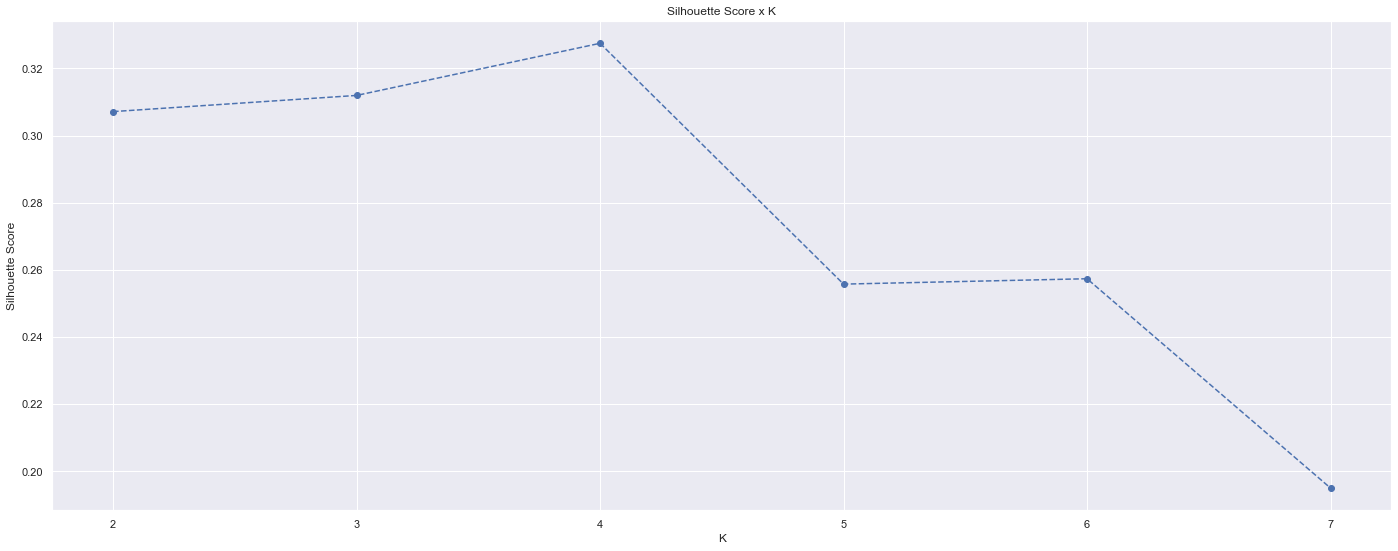

In [53]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2. GMM

In [54]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

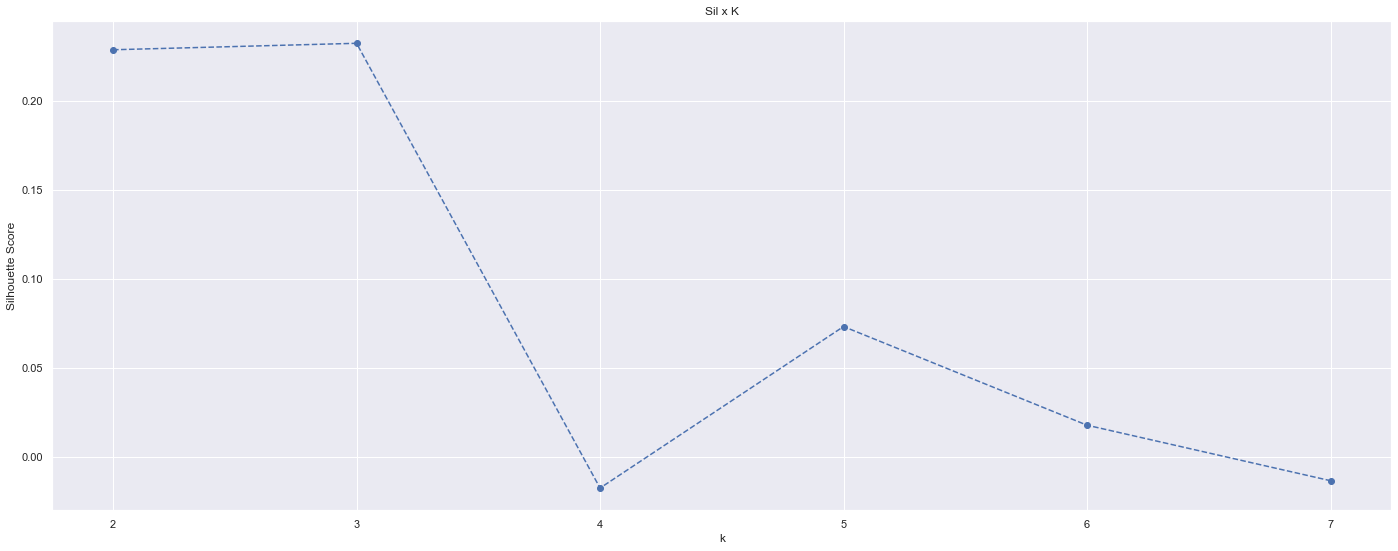

In [55]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 7.3. Hierarchical Clustering

In [56]:
from scipy.cluster import hierarchy as hc

In [57]:
# model definition and training
hc_model = hc.linkage( X, 'ward' )

In [58]:
hc.dendrogram( 
    hc_model, 
    leaf_rotation=90,
    leaf_font_size=8
)

plt.plot()

[]

In [59]:
hc.dendrogram( 
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True
)

plt.show()

### 7.3.1. HClustering Silhouette Score

In [60]:
from sklearn import metrics as m

In [61]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

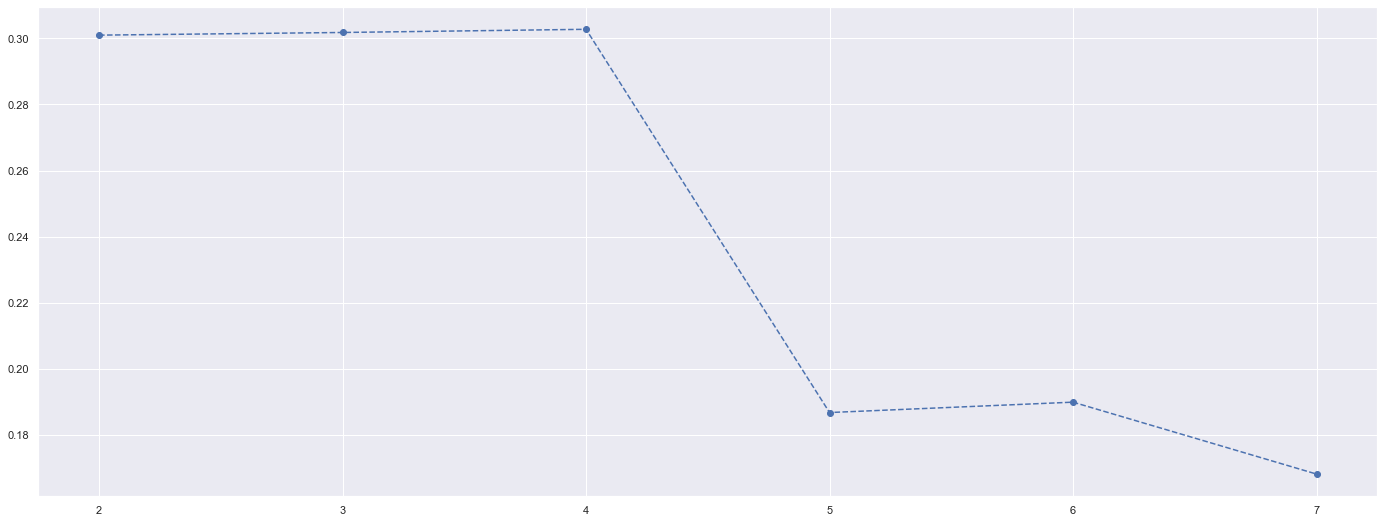

In [62]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

## 7.5. Results

In [68]:
df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list, 
    }
).T

df_results.columns = clusters

In [69]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

## 7.6. Silhouette Analysis

In [70]:
fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = m.silhouette_score( X, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

 For K = 2. Silhouette Score: 0.3009852783052706
 For K = 3. Silhouette Score: 0.30179007206858643
 For K = 4. Silhouette Score: 0.3027530437448889
 For K = 5. Silhouette Score: 0.18676084487449787
 For K = 6. Silhouette Score: 0.18990085325250072
 For K = 7. Silhouette Score: 0.16813961183141918


# <font color='red'> 8.0 HYPERPARAMETER FINE TUNNING </font>

## 8.1. K-Means

In [71]:
# model definition
k = 4
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42) #max_iter iterações para achar o centróide

# model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [72]:
## WSS (within-cluster sum of square)
print('WSS Values: {}'.format(kmeans.inertia_))

## SS (Silhouette Score)
print('SS Values: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS Values: 526.6249121472349
SS Values: 0.3274743811001432


# <font color='red'> 9.0. Cluster Analysis </font>

In [73]:
df9 = df5_p.copy()
df9['cluster'] = labels
df9['trab_renda'] = (df9['trab_renda_max'] + df9['trab_renda_min'])/2
df9['renda_per_cap'] = (df9['renda_per_cap_max'] + df9['renda_per_cap_min'])/2
df9['renda_fam'] = (df9['renda_fam_max'] + df9['renda_fam_min'])/2
df9.head()

municipio.uf  trabalhadores  s_dom_part_perm  s_tx_cresc_renda_media  s_comercializacao  autonomo  micro_peq_empresas  media_empresas  grande_empresas  s_pct_setor_primario  s_pct_setor_secundario  s_pct_setor_terciario  s_pct_setor_outros  pop_estimada  trab_renda_max  trab_renda_min  renda_fam_max  renda_fam_min  renda_per_cap_max  renda_per_cap_min  dens_max  dens_min  taxa_dens  taxa_exp_cidade  taxa_comercio_mercados  forca_classe_alta  forca_classe_baixa  dif_social  cluster  trab_renda  renda_per_cap  renda_fam
0       ac / acrelandia         492.29          2323.96                    0.27               5.96    317.21               56.96            1.92             0.00                  1.22                   14.37                  80.53                3.74         15490         1698.42         1576.98        1641.58        1514.37             537.78             500.45     51.95     44.94       1.16             0.63                    0.07               0.34                1.64        4.86        2     1637.70         519.11    1577.97
1        ac / brasileia        1850.69          6230.69                   -0.63              10.20    927.36              201.02            2.50             0.95                  0.29                    8.72                  89.78                1.22         26702         1211.65         1160.25        1933.95        1772.20             673.11             603.38   3069.11    708.41       4.33             0.64                    0.09               0.68                1.71        2.52        2     1185.95         638.24    1853.07
2         ac / capixaba         432.00          1618.00                    1.93               5.82    242.00               30.00            2.00             0.00                  3.36                   13.76                  80.54                2.35         12008         1639.39         1639.39        1790.39        1790.39             548.34             548.34    105.58    105.58       1.00             0.85                    0.07               0.29                1.67        5.85        2     1639.39         548.34    1790.39
3  ac / cruzeiro do sul        3075.13          8595.12                    0.85              10.80   1540.87              298.63            5.26             0.52                  0.44                   11.46                  87.36                0.69         89072         1285.75          916.25        2261.27         677.87             637.98             184.72   1656.20      5.64     293.65             0.52                    0.12               0.74                1.90        2.56        2     1101.00         411.35    1469.57
4   ac / epitaciolandia        1659.12          4344.29                    0.39               9.66    696.00              171.71            3.24             0.41                  0.21                    8.43                  89.89                1.46         18696         1247.43         1247.43        1721.90        1721.90             593.70             593.70   1188.04   1188.04       1.00             0.61                    0.09               0.73                1.61        2.21        2     1247.43         593.70    1721.90

In [74]:
ordem = ['municipio.uf', 'pop_estimada','trabalhadores', 'trab_renda', 'renda_per_cap', 'renda_fam',
         's_dom_part_perm',
         's_tx_cresc_renda_media', 's_comercializacao', 'autonomo',
         'micro_peq_empresas', 'media_empresas', 'grande_empresas',
         's_pct_setor_primario', 's_pct_setor_secundario',
         's_pct_setor_terciario', 's_pct_setor_outros', 
         'taxa_dens', 'taxa_exp_cidade', 'taxa_comercio_mercados',
         'forca_classe_alta', 'forca_classe_baixa', 'dif_social', 'cluster',
         ]
df9 = df9[ordem]

In [75]:
#df9 = df9.groupby('municipio.uf').mean().reset_index()

## 9.1. Visualization Inspection

In [76]:
df_aux = df9[['trab_renda', 'renda_per_cap', 'renda_fam', 'cluster']]
fig = px.scatter_3d(df_aux, x='trab_renda', y='renda_per_cap', z='renda_fam', color='cluster')
fig.show();

## 9.2. 2d plot

In [77]:
#df_viz = df9.drop( columns='municipio.uf', axis=1 )
#sns.pairplot( df_viz, hue='cluster' );

In [78]:
df9.columns

Index(['municipio.uf', 'pop_estimada', 'trabalhadores', 'trab_renda',
       'renda_per_cap', 'renda_fam', 's_dom_part_perm',
       's_tx_cresc_renda_media', 's_comercializacao', 'autonomo',
       'micro_peq_empresas', 'media_empresas', 'grande_empresas',
       's_pct_setor_primario', 's_pct_setor_secundario',
       's_pct_setor_terciario', 's_pct_setor_outros', 'taxa_dens',
       'taxa_exp_cidade', 'taxa_comercio_mercados', 'forca_classe_alta',
       'forca_classe_baixa', 'dif_social', 'cluster'],
      dtype='object')

## 9.1. Cluster Profile

In [79]:
df_cluster = pd.DataFrame()
# Number of municipalities
df_cluster = df9[['municipio.uf', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_municipio'] = 100*(df_cluster['municipio.uf'] / df_cluster['municipio.uf'].sum())

# Avg of workers
df_avg_trabalhador = df9[['trabalhadores', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'trabalhadores':'avg_trabalhadores'})
df_cluster = pd.merge(df_cluster, df_avg_trabalhador, how='inner', on='cluster')

# Avg density rate
df_avg_taxa_dens = df9[['taxa_dens', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'taxa_dens':'avg_taxa_dens'})
df_cluster = pd.merge(df_cluster, df_avg_taxa_dens, how='inner', on='cluster')

# Avg estimated population
df_pop_estimada = df9[['pop_estimada', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'pop_estimada':'avg_pop_estimada'})
df_cluster = pd.merge(df_cluster, df_pop_estimada, how='inner', on='cluster')

# Avg workers income
df_trab_renda = df9[['trab_renda', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'trab_renda':'avg_trab_renda'})
df_cluster = pd.merge(df_cluster, df_trab_renda, how='inner', on='cluster')

# Avg per capita income
df_renda_per_cap = df9[['renda_per_cap', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'renda_per_cap':'avg_renda_per_cap'})
df_cluster = pd.merge(df_cluster, df_renda_per_cap, how='inner', on='cluster')

# Avg family income
df_renda_fam = df9[['renda_fam', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'renda_fam':'avg_renda_fam'})
df_cluster = pd.merge(df_cluster, df_renda_fam, how='inner', on='cluster')

# Avg social difference rate
df_dif_social = df9[['dif_social', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'dif_social':'avg_dif_social'})
df_cluster = pd.merge(df_cluster, df_dif_social, how='inner', on='cluster')

In [80]:
df_cluster.sort_values('avg_trab_renda', ascending=False)

cluster  municipio.uf  perc_municipio  avg_trabalhadores  avg_taxa_dens  avg_pop_estimada  avg_trab_renda  avg_renda_per_cap  avg_renda_fam  avg_dif_social
0        0           381            7.27            9407.45         402.62         320756.40         2019.42            1626.41        4470.94            6.87
1        1           319            6.09             983.42           5.57          10780.75         1530.56             895.49        2553.26            7.93
3        3          2131           40.68            1383.53          24.82          17878.47         1457.14            1066.04        2910.45            7.77
2        2          2407           45.95             678.45           7.38          18650.93         1255.66             547.46        1655.48            6.23

### Cluster 01:  ("Vem de Bolo" Candidate)
    - Total number of municipalities: 381 (7.27%)
    - Average number of workers: 9407,45
    - Average population of municipalities: 320.756,40
    - Average income from workers: R$ 2.019,42	
- Average Renda per capita income: R$ 2.471,81
    - Average family household income: R$ 4.470,94
        
### Cluster 02: (Small municipalities with better income - all in the state of São Paulo)
    - Total number of municipalities: 319
    - Average number of workers: 983,42
    - Average population of municipalities: 10.780,75
    - Average income from workers: R$ 1.540,56	
- Average Renda per capita income: R$ 895,49
    - Average family household income: R$ 2.553,26

### Cluster 03: (Municipalities with income, but small)
    - Total number of municipalities: 2131
    - Average number of workers: 1383,53
    - Average population of municipalities: 17.878,47	
    - Average income from workers: R$ 1.457,14	
- Average Renda per capita income: R$ 1.066,04
    - Average family household income: R$ 2.910,45
    
### Cluster 04: (Small municipalities with low income)
    - Total number of municipalities: 2407
    - Average number of workers: 678,45
    - Average population of municipalities: 18.650,93	
    - Average income from workers: R$ 1.255,66
    - Average Renda per capita income: R$ 547,46
    - Average family household income: R$ 1.655,48

In [81]:
df9[df9['cluster'] == 0].sort_values('renda_fam', ascending=False).head(10)

municipio.uf  pop_estimada  trabalhadores  trab_renda  renda_per_cap  renda_fam  s_dom_part_perm  s_tx_cresc_renda_media  s_comercializacao  autonomo  micro_peq_empresas  media_empresas  grande_empresas  s_pct_setor_primario  s_pct_setor_secundario  s_pct_setor_terciario  s_pct_setor_outros  taxa_dens  taxa_exp_cidade  taxa_comercio_mercados  forca_classe_alta  forca_classe_baixa  dif_social  cluster
780              df / brasilia       3055149       17394.38     9288.14        5813.00   18101.05         19376.22                    1.42              12.87   3701.66              786.01           20.38             2.21                  0.20                   14.52                  84.48                0.79    4901.66             0.60                    0.03               1.82               12.35        6.77        0
1704            mg / nova lima         96157        9449.47     3798.79        5851.55   16222.31          7572.88                    3.19              20.27   1667.70              522.29           21.04             2.26                  0.30                   15.70                  83.40                0.56      65.37             0.69                    0.02               1.46               11.74        8.03        0
3372       rj / rio de janeiro       6747815       34928.06     4142.34        5663.85   15713.64         38780.12                    1.82              14.59   9001.39             1949.71           70.27             7.51                  0.11                   14.05                  85.32                0.50     767.80             0.40                    0.02               1.77               18.23       10.29        0
5041            sp / sao paulo      12325232       49978.00     3672.95        6414.34   15542.69         44832.60                    0.94              20.42  12442.99             2814.43          100.44            10.10                  0.11                   13.65                  85.78                0.44     319.74             0.40                    0.02               1.94               15.40        7.95        0
5011  sp / santana de parnaiba        142301        8111.02     2897.66        5246.14   15412.81          7024.17                    2.47              32.93   2209.97              361.93           22.85             2.01                  0.42                   13.04                  86.21                0.30      19.07             0.66                    0.02               1.31                9.74        7.43        0
1323       mg / belo horizonte       2521564       49468.26     3905.99        5302.39   14670.92         32899.87                    0.77              20.11   9210.76             2896.85           93.50            10.25                  0.13                   14.81                  84.49                0.51      67.15             0.30                    0.02               2.06               13.23        6.42        0
4542              sp / barueri        276982       28458.96     2548.67        5668.60   14533.25         19921.28                    1.22              24.25   4443.11              954.69           77.68             8.58                  0.09                   14.12                  85.32                0.45      32.69             0.52                    0.03               1.14               12.03       10.52        0
939               go / goiania       1536097       19467.33     2790.57        3902.32   12451.28         19477.07                    0.62              14.25   3908.22             1328.96           36.70             2.93                  0.32                   18.89                  80.21                0.58     816.67             0.58                    0.02               2.25                8.11        3.60        0
858               es / vitoria        365855       26335.48     4186.89        4525.96   11130.36         23227.75                    1.88              19.08   5514.62             1759.05           56.07             4.40

In [82]:
df9[df9['cluster'] == 1].sort_values('renda_fam', ascending=False)

municipio.uf  pop_estimada  trabalhadores  trab_renda  renda_per_cap  renda_fam  s_dom_part_perm  s_tx_cresc_renda_media  s_comercializacao  autonomo  micro_peq_empresas  media_empresas  grande_empresas  s_pct_setor_primario  s_pct_setor_secundario  s_pct_setor_terciario  s_pct_setor_outros  taxa_dens  taxa_exp_cidade  taxa_comercio_mercados  forca_classe_alta  forca_classe_baixa  dif_social  cluster
4753                   sp / ituverava         42045        4076.08     1488.15        1569.90    4244.71          6924.11                   -0.28              16.84   2048.20              435.78           10.32             0.71                 31.46                    7.98                  59.76                0.77       1.07             0.39                    0.02               1.89                6.37        3.37        1
4985                    sp / saltinho          8393        1398.84     1918.59        1296.65    3899.74          2813.16                    0.28              20.29   1348.56              183.91            4.75             0.00                 33.47                   21.87                  44.12                0.54       1.10             0.66                    0.02               2.16               16.67        7.71        1
4825                     sp / mombuca          3508         414.67     1867.83        1280.64    3884.98           574.67                    0.08              15.60    633.00               30.33            2.33             0.00                 71.51                    6.72                  20.56                1.20       1.00             0.11                    0.02               1.06                6.66        6.26        1
4995     sp / santa cruz da conceicao          4544         503.00     1606.97        1346.67    3825.45          1211.91                    0.75              13.02    428.31               46.09            1.75             0.00                 31.11                   14.35                  53.17                1.36       1.40             0.49                    0.03               1.32               15.07       11.43        1
4717             sp / inubia paulista          4019        6798.00     2211.90        1341.84    3769.40          8232.00                    1.22              14.22   2050.00              561.00           11.33             0.67                 28.80                   12.73                  56.91                1.56      74.32             0.42                    0.02               2.10                7.99        3.81        1
4857              sp / novo horizonte         41414        3301.26     1439.32        1386.03    3700.04          7900.24                    0.86              15.82   1787.74              459.06            3.87             0.96                 33.41                    7.61                  58.09                0.89       3.83             0.54                    0.03               1.37                7.07        5.16        1
5087                       sp / tiete         42517        3429.98     1531.56        1236.63    3603.59          5172.41                   -0.28              16.16   1403.15              318.08            9.52             0.40                 22.30                   19.62                  57.40                0.66       5.00             0.55                    0.02               1.63               11.61        7.10        1
4692                   sp / guatapara          7709         388.67     1515.43        1184.29    3579.61          1047.87                   -0.95               5.28    653.53               43.07            0.93             0.00                 55.39                    7.75                  36.17                0.69       9.45             0.49                    0.02               0.96                5.46        5.65        1
4983                 sp / salesopolis         17252        1628.86     1514.41        1176.93    3489.06          4048.29                    2.23              11.00

In [83]:
# Classification by city size
df_aux = df9.copy()
df_aux['class_cidade'] = df_aux.apply(lambda x: 'baixa' if (x['pop_estimada'] < 50000) 
                                else 'media_pequena' if (x['pop_estimada'] >= 50000) & (x['pop_estimada'] < 100000)
                                else 'media' if (x['pop_estimada'] >= 100000) & (x['pop_estimada'] < 300000)
                                else 'media_grande' if (x['pop_estimada'] >= 300000) & (x['pop_estimada'] < 500000)
                                else 'grande', axis=1)

In [84]:
df_aux[['class_cidade', 'municipio.uf']].groupby('class_cidade').count()

municipio.uf
class_cidade               
baixa                  4565
grande                   49
media                   231
media_grande             46
media_pequena           347

# <font color='red'> 10.0. EDA </font>

## CLUSTER 01 - VEM DE BOLO CANDIDATE

In [85]:
cls_zero = df9[df9['cluster'] == 0].copy()

In [86]:
cls_zero = cls_zero.sort_values('renda_fam', ascending=False)

In [87]:
cls_zero.head()

municipio.uf  pop_estimada  trabalhadores  trab_renda  renda_per_cap  renda_fam  s_dom_part_perm  s_tx_cresc_renda_media  s_comercializacao  autonomo  micro_peq_empresas  media_empresas  grande_empresas  s_pct_setor_primario  s_pct_setor_secundario  s_pct_setor_terciario  s_pct_setor_outros  taxa_dens  taxa_exp_cidade  taxa_comercio_mercados  forca_classe_alta  forca_classe_baixa  dif_social  cluster
780              df / brasilia       3055149       17394.38     9288.14        5813.00   18101.05         19376.22                    1.42              12.87   3701.66              786.01           20.38             2.21                  0.20                   14.52                  84.48                0.79    4901.66             0.60                    0.03               1.82               12.35        6.77        0
1704            mg / nova lima         96157        9449.47     3798.79        5851.55   16222.31          7572.88                    3.19              20.27   1667.70              522.29           21.04             2.26                  0.30                   15.70                  83.40                0.56      65.37             0.69                    0.02               1.46               11.74        8.03        0
3372       rj / rio de janeiro       6747815       34928.06     4142.34        5663.85   15713.64         38780.12                    1.82              14.59   9001.39             1949.71           70.27             7.51                  0.11                   14.05                  85.32                0.50     767.80             0.40                    0.02               1.77               18.23       10.29        0
5041            sp / sao paulo      12325232       49978.00     3672.95        6414.34   15542.69         44832.60                    0.94              20.42  12442.99             2814.43          100.44            10.10                  0.11                   13.65                  85.78                0.44     319.74             0.40                    0.02               1.94               15.40        7.95        0
5011  sp / santana de parnaiba        142301        8111.02     2897.66        5246.14   15412.81          7024.17                    2.47              32.93   2209.97              361.93           22.85             2.01                  0.42                   13.04                  86.21                0.30      19.07             0.66                    0.02               1.31                9.74        7.43        0

In [88]:
cls_zero = cls_zero.sort_values('renda_fam', ascending=False)
cls_zero.to_excel('cluster_candidato.xls')

In [89]:
# Classification by city size
cls_zero['class_cidade'] = cls_zero.apply(lambda x: 'baixa' if (x['pop_estimada'] < 50000) 
                                else 'media_pequena' if (x['pop_estimada'] >= 50000) & (x['pop_estimada'] < 100000)
                                else 'media' if (x['pop_estimada'] >= 100000) & (x['pop_estimada'] < 300000)
                                else 'media_grande' if (x['pop_estimada'] >= 300000) & (x['pop_estimada'] < 500000)
                                else 'grande', axis=1)

In [90]:
# Checking the representative of cities chosen by the model in each state
aux = df1[['municipio.uf', 'uf']]
aux = aux.drop_duplicates(subset='municipio.uf')

aux2 = aux.groupby('uf').count().sort_values('municipio.uf', ascending=False).reset_index().rename(columns={'municipio.uf': 'total_municipios'})

cls_zero = pd.merge(cls_zero, aux, on='municipio.uf', how='left')
rank = cls_zero[['uf','municipio.uf']].groupby('uf').count().reset_index()
rank = pd.merge(rank, aux2, on='uf', how='left')
rank['part_municip'] = rank['municipio.uf'] / rank['total_municipios'] *100

In [91]:
rank.sort_values('municipio.uf', ascending=False)

uf  municipio.uf  total_municipios  part_municip
25  sp           114               644         17.70
10  mg            52               715          7.27
22  rs            34               495          6.87
17  pr            28               397          7.05
23  sc            26               293          8.87
18  rj            24                92         26.09
4   ba            17               417          4.08
15  pe            15               184          8.15
8   go            10               218          4.59
7   es            10                78         12.82
13  pa             8               117          6.84
5   ce             7               184          3.80
12  mt             5               105          4.76
20  ro             4                42          9.52
11  ms             4                77          5.19
14  pb             4               220          1.82
19  rn             3               165          1.82
26  to             3               116          2.59
9   ma             3               191          1.57
1   al             2               102          1.96
24  se             2                74          2.70
16  pi             1               222          0.45
21  rr             1                12          8.33
6   df             1                 1        100.00
3   ap             1                 6         16.67
2   am             1                58          1.72
0   ac             1                13          7.69

In [92]:
# DF with lat long of each city
df_munc_loc = pd.read_csv('../data/external/munc_lat_long_r01.csv')
df_munc_loc = df_munc_loc[['nome', 'latitude', 'longitude','codigo_uf']]
df_munc_loc['nome'] = df_munc_loc['nome'].apply(lambda x: str.lower(x))
df_munc_loc['nome'] = df_munc_loc['nome'].apply(lambda x: unidecode(x))

# DF with UF code (estate code)
df_uf_cod = pd.read_csv('../data/external/uf_codigo.csv')
df_uf_cod = df_uf_cod[['codigo_uf', 'uf']]
df_uf_cod['uf'] = df_uf_cod['uf'].apply(lambda x: str.lower(x))

df_munc_loc = pd.merge(df_munc_loc, df_uf_cod, on='codigo_uf', how='left')
df_munc_loc = df_munc_loc.drop('codigo_uf', axis=1)
df_munc_loc['municipio.uf'] = df_munc_loc['uf'] + ' / ' + df_munc_loc['nome']
df_munc_loc = df_munc_loc[['municipio.uf', 'latitude', 'longitude', 'uf', 'nome']]

In [93]:
df_municip_lat_log = pd.merge(df_municip, df_munc_loc, on='municipio.uf', how='left')
df_municip_lat_log = df_municip_lat_log[['municipio.uf', 'latitude', 'longitude']]

In [94]:
cls_zero_map = pd.merge(cls_zero, df_municip_lat_log, on='municipio.uf', how='left')
cls_zero_map = cls_zero_map[['municipio.uf', 'latitude', 'longitude', 'pop_estimada']].copy()

In [95]:
fig = px.scatter_mapbox(cls_zero_map,
                         lat='latitude',
                         lon='longitude',
                         #size='pop_estimada',
                         color_continuous_scale=px.colors.cyclical.IceFire,
                         size_max=15,
                         zoom=10)

fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(height=600, margin={'r':0, 'l':0, 't':0, 'b':0})
fig.show()

In [96]:
cls_zero.sort_values('renda_fam', ascending=False)

municipio.uf  pop_estimada  trabalhadores  trab_renda  renda_per_cap  renda_fam  s_dom_part_perm  s_tx_cresc_renda_media  s_comercializacao  autonomo  micro_peq_empresas  media_empresas  grande_empresas  s_pct_setor_primario  s_pct_setor_secundario  s_pct_setor_terciario  s_pct_setor_outros  taxa_dens  taxa_exp_cidade  taxa_comercio_mercados  forca_classe_alta  forca_classe_baixa  dif_social  cluster   class_cidade  uf
0                    df / brasilia       3055149       17394.38     9288.14        5813.00   18101.05         19376.22                    1.42              12.87   3701.66              786.01           20.38             2.21                  0.20                   14.52                  84.48                0.79    4901.66             0.60                    0.03               1.82               12.35        6.77        0         grande  df
1                   mg / nova lima         96157        9449.47     3798.79        5851.55   16222.31          7572.88                    3.19              20.27   1667.70              522.29           21.04             2.26                  0.30                   15.70                  83.40                0.56      65.37             0.69                    0.02               1.46               11.74        8.03        0  media_pequena  mg
2              rj / rio de janeiro       6747815       34928.06     4142.34        5663.85   15713.64         38780.12                    1.82              14.59   9001.39             1949.71           70.27             7.51                  0.11                   14.05                  85.32                0.50     767.80             0.40                    0.02               1.77               18.23       10.29        0         grande  rj
3                   sp / sao paulo      12325232       49978.00     3672.95        6414.34   15542.69         44832.60                    0.94              20.42  12442.99             2814.43          100.44            10.10                  0.11                   13.65                  85.78                0.44     319.74             0.40                    0.02               1.94               15.40        7.95        0         grande  sp
4         sp / santana de parnaiba        142301        8111.02     2897.66        5246.14   15412.81          7024.17                    2.47              32.93   2209.97              361.93           22.85             2.01                  0.42                   13.04                  86.21                0.30      19.07             0.66                    0.02               1.31                9.74        7.43        0          media  sp
5              mg / belo horizonte       2521564       49468.26     3905.99        5302.39   14670.92         32899.87                    0.77              20.11   9210.76             2896.85           93.50            10.25                  0.13                   14.81                  84.49                0.51      67.15             0.30                    0.02               2.06               13.23        6.42        0         grande  mg
6                     sp / barueri        276982       28458.96     2548.67        5668.60   14533.25         19921.28                    1.22              24.25   4443.11              954.69           77.68             8.58                  0.09                   14.12                  85.32                0.45      32.69             0.52                    0.03               1.14               12.03       10.52        0          media  sp
7                     go / goiania       1536097       19467.33     2790.57        3902.32   12451.28         19477.07                    0.62              14.25   3908.22             1328.96           36.70             2.93                  0.32                   18.89                  80.21                0.58     816.67             0.58                    0.02               2.25                8.11        3.60        0         grande  go
8                

In [97]:
cls_zero[['uf', 'class_cidade', 'cluster']].groupby(['uf', 'class_cidade']).count()

cluster
uf class_cidade          
ac media_grande         1
al grande               1
   media                1
am grande               1
ap grande               1
ba grande               2
   media               11
   media_grande         2
   media_pequena        2
ce grande               1
   media                5
   media_pequena        1
df grande               1
es baixa                1
   grande               2
   media                5
   media_grande         2
go grande               2
   media                6
   media_grande         1
   media_pequena        1
ma grande               1
   media                2
mg baixa                2
   grande               4
   media               23
   media_grande         4
   media_pequena       19
ms grande               1
   media                3
mt grande               1
   media                3
   media_pequena        1
pa grande               2
   media                5
   media_grande         1
pb grande               1
   media_grande         1
   media_pequena        2
pe grande               2
   media                5
   media_grande         4
   media_pequena        4
pi grande               1
pr grande               2
   media               13
   media_grande         4
   media_pequena        9
rj grande               7
   media               13
   media_grande         2
   media_pequena        2
rn grande               1
   media                1
   media_grande         1
ro grande               1
   media                2
   media_pequena        1
rr media_grande         1
rs baixa                1
   grande               2
   media               14
   media_grande         2
   media_pequena       15
sc baixa                4
   grande               2
   media               10
   media_grande         1
   media_pequena        9
se grande               1
   media_pequena        1
sp baixa                4
   grande               9
   media               51
   media_grande        17
   media_pequena       33
to media                1
   media_grande         1
   media_pequena        1

In [98]:
aux = cls_zero[cls_zero['uf']=='sp']
aux.groupby('uf').mean()

pop_estimada  trabalhadores  trab_renda  renda_per_cap  renda_fam  s_dom_part_perm  s_tx_cresc_renda_media  s_comercializacao  autonomo  micro_peq_empresas  media_empresas  grande_empresas  s_pct_setor_primario  s_pct_setor_secundario  s_pct_setor_terciario  s_pct_setor_outros  taxa_dens  taxa_exp_cidade  taxa_comercio_mercados  forca_classe_alta  forca_classe_baixa  dif_social  cluster
uf                                                                                                                                                                                                                                                                                                                                                                                                       
sp     328184.42        9284.00     2146.18        1715.47    4807.93         15452.54                    0.54              15.76   3164.47              724.85           21.42             1.62                  5.87                   16.33                  77.13                0.64     185.09             0.47                    0.03               1.78               10.63        6.80        0

In [99]:
aux[['municipio.uf', 'pop_estimada']]

municipio.uf  pop_estimada
3                sp / sao paulo      12325232
4      sp / santana de parnaiba        142301
6                  sp / barueri        276982
9                 sp / campinas       1213792
12             sp / carapicuiba        403183
17                   sp / cotia        253608
19                 sp / vinhedo         80111
24   sp / sao jose do rio preto        464983
25             sp / santo andre        721368
26                sp / valinhos        131210
27     sp / sao jose dos campos        729737
28          sp / ribeirao preto        711825
29      sp / sao caetano do sul        161957
38                  sp / osasco        699944
39                 sp / jundiai        423006
42                   sp / aruja         91157
43          sp / embu das artes        276535
48                 sp / itatiba        122581
49                   sp / bauru        379297
50         sp / mogi das cruzes        450785
53                sp / paulinia        112003
54         sp / taboao da serra        293652
55   sp / sao bernardo do campo        844483
56                sp / sorocaba        687357
59               sp / guarulhos       1392121
68              sp / indaiatuba        256223
69     sp / presidente prudente        230371
70       sp / braganca paulista        170533
71                  sp / santos        433656
80             sp / jaboticabal         77652
82               sp / americana        242018
88                 sp / atibaia        144088
89              sp / piracicaba        407252
90   sp / sao joao da boa vista         91771
95          sp / ribeirao pires        124159
97                 sp / diadema        426757
102                sp / guaruja        322750
104                sp / taubate        317915
111                    sp / itu        175568
117             sp / votorantim        123599
118             sp / sao carlos        254484
119              sp / aracatuba        198129
124   sp / itapecerica da serra        177662
125                 sp / suzano        300559
126                sp / marilia        240590
133              sp / rio claro        208008
135        sp / pindamonhangaba        170132
136          sp / guaratingueta        122505
137            sp / sertaozinho        127142
138                sp / limeira        308482
140                  sp / salto        119736
142                sp / boituva         62170
149                   sp / maua        477552
152             sp / jaguariuna         58722
154        sp / itaquaquecetuba        375011
157                 sp / araras        135506
166             sp / araraquara        238339
168                 sp / amparo         72677
175                sp / itupeva         62813
176              sp / cerquilho         49802
177                  sp / assis        105087
182                 sp / franca        355901
184               sp / botucatu        148130
190                   sp / lins         78503
193  sp / santa barbara d'oeste        194390
197          sp / fernandopolis         69402
198            sp / sao vicente        368355
200               sp / ourinhos        114352
205                    sp / jau        151881
208              sp / sao roque         92060
209       sp / lencois paulista         68990
210                 sp / sumare        286211
212               sp / mirassol         60303
213                sp / jandira        126356
216               sp / batatais         62980
223           sp / pirassununga         76877
227               sp / pedreira         48463
228           sp / barra bonita         36126
237             sp / adamantina         35111
238                    sp / poa        118349
241            sp / nova odessa         60956
242               sp / barretos        122833
244                  sp / avare         91232
247              sp / bebedouro         77555
249              sp / catanduva        122497
251             sp / mogi mirim         93650
254         sp / 

## CLUSTER 02 - Small municipalities with better income - all in the state of São Paulo

In [100]:
cls_um = df9[df9['cluster'] == 1].copy()

In [101]:
cls_um.to_csv('cluster_um_outro.csv', index=False)

In [102]:
cls_um = cls_um.sort_values('renda_fam', ascending=False)
cls_um.to_excel('cluster_um.xls')

In [103]:
# Classification by city size
cls_um['class_cidade'] = cls_um.apply(lambda x: 'baixa' if (x['pop_estimada'] < 50000) 
                                else 'media_pequena' if (x['pop_estimada'] >= 50000) & (x['pop_estimada'] < 100000)
                                else 'media' if (x['pop_estimada'] >= 100000) & (x['pop_estimada'] < 300000)
                                else 'media_grande' if (x['pop_estimada'] >= 300000) & (x['pop_estimada'] < 500000)
                                else 'grande', axis=1)

In [104]:
cls_um.head()

municipio.uf  pop_estimada  trabalhadores  trab_renda  renda_per_cap  renda_fam  s_dom_part_perm  s_tx_cresc_renda_media  s_comercializacao  autonomo  micro_peq_empresas  media_empresas  grande_empresas  s_pct_setor_primario  s_pct_setor_secundario  s_pct_setor_terciario  s_pct_setor_outros  taxa_dens  taxa_exp_cidade  taxa_comercio_mercados  forca_classe_alta  forca_classe_baixa  dif_social  cluster class_cidade
4753                sp / ituverava         42045        4076.08     1488.15        1569.90    4244.71          6924.11                   -0.28              16.84   2048.20              435.78           10.32             0.71                 31.46                    7.98                  59.76                0.77       1.07             0.39                    0.02               1.89                6.37        3.37        1        baixa
4985                 sp / saltinho          8393        1398.84     1918.59        1296.65    3899.74          2813.16                    0.28              20.29   1348.56              183.91            4.75             0.00                 33.47                   21.87                  44.12                0.54       1.10             0.66                    0.02               2.16               16.67        7.71        1        baixa
4825                  sp / mombuca          3508         414.67     1867.83        1280.64    3884.98           574.67                    0.08              15.60    633.00               30.33            2.33             0.00                 71.51                    6.72                  20.56                1.20       1.00             0.11                    0.02               1.06                6.66        6.26        1        baixa
4995  sp / santa cruz da conceicao          4544         503.00     1606.97        1346.67    3825.45          1211.91                    0.75              13.02    428.31               46.09            1.75             0.00                 31.11                   14.35                  53.17                1.36       1.40             0.49                    0.03               1.32               15.07       11.43        1        baixa
4717          sp / inubia paulista          4019        6798.00     2211.90        1341.84    3769.40          8232.00                    1.22              14.22   2050.00              561.00           11.33             0.67                 28.80                   12.73                  56.91                1.56      74.32             0.42                    0.02               2.10                7.99        3.81        1        baixa

In [105]:
# Checking the representative of cities chosen by the model in each state
aux = df1[['municipio.uf', 'uf']]
aux = aux.drop_duplicates(subset='municipio.uf')

aux2 = aux.groupby('uf').count().sort_values('municipio.uf', ascending=False).reset_index().rename(columns={'municipio.uf': 'total_municipios'})

cls_um = pd.merge(cls_um, aux, on='municipio.uf', how='left')
rank = cls_um[['uf','municipio.uf']].groupby('uf').count().reset_index()
rank = pd.merge(rank, aux2, on='uf', how='left')
rank['part_municip'] = rank['municipio.uf'] / rank['total_municipios'] *100

In [106]:
rank.sort_values('part_municip', ascending=False)

uf  municipio.uf  total_municipios  part_municip
1  sp           318               644         49.38
0  mg             1               715          0.14

In [107]:
cls_um_map = pd.merge(cls_um, df_municip_lat_log, on='municipio.uf', how='left')
cls_um_map = cls_um_map[['municipio.uf', 'latitude', 'longitude', 'pop_estimada']].copy()

In [108]:
fig = px.scatter_mapbox(cls_um_map,
                         lat='latitude',
                         lon='longitude',
                         #size='pop_estimada',
                         color_continuous_scale=px.colors.cyclical.IceFire,
                         size_max=15,
                         zoom=10)

fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(height=600, margin={'r':0, 'l':0, 't':0, 'b':0})
fig.show()

## CLUSTER 03 - Municipalities with income, but small

In [109]:
cls_dois = df9[df9['cluster'] == 3].copy()

In [110]:
cls_dois.to_csv('cluster_dois_outro.csv', index=False)

In [111]:
cls_dois = cls_dois.sort_values('renda_fam', ascending=False)
cls_dois.to_excel('cluster_dois.xls')

In [112]:
# Classification by city size
cls_dois['class_cidade'] = cls_dois.apply(lambda x: 'baixa' if (x['pop_estimada'] < 50000) 
                                else 'media_pequena' if (x['pop_estimada'] >= 50000) & (x['pop_estimada'] < 100000)
                                else 'media' if (x['pop_estimada'] >= 100000) & (x['pop_estimada'] < 300000)
                                else 'media_grande' if (x['pop_estimada'] >= 300000) & (x['pop_estimada'] < 500000)
                                else 'grande', axis=1)

In [113]:
cls_dois.head()

municipio.uf  pop_estimada  trabalhadores  trab_renda  renda_per_cap  renda_fam  s_dom_part_perm  s_tx_cresc_renda_media  s_comercializacao  autonomo  micro_peq_empresas  media_empresas  grande_empresas  s_pct_setor_primario  s_pct_setor_secundario  s_pct_setor_terciario  s_pct_setor_outros  taxa_dens  taxa_exp_cidade  taxa_comercio_mercados  forca_classe_alta  forca_classe_baixa  dif_social  cluster class_cidade
4799        sp / mairipora        101937        2222.03     1614.18        2407.22    7482.68          5600.96                    1.69              12.29    946.29              196.60            5.06             0.29                  1.21                   19.91                  78.04                0.83       5.79             0.71                    0.03               1.06               10.41        9.78        3        media
4401        sc / xavantina          3903         276.42     1326.56        2136.19    6353.49           676.50                    8.75               8.52    116.25               43.75            0.83             0.00                  0.77                   17.45                  76.03                5.76       1.19            -0.17                    0.03               1.21               11.61        9.62        3        baixa
991        go / mossamedes          4206         407.00     1170.15        2134.62    6048.10            60.00                    6.57               0.00    133.00               52.00            2.00             0.00                  1.47                   18.63                  78.43                1.47       1.00             1.98                    0.14               0.91                3.03        3.35        3        baixa
4255   sc / lajeado grande          1418         160.00     1709.81        1994.29    5813.81           637.00                    2.34              11.77     64.00               14.00            1.00             0.00                  2.06                   30.93                  56.70               10.31       1.00            -0.66                    0.03               1.37               13.78       10.07        3        baixa
3824  rs / ipiranga do sul          1880         191.00     2114.44        2176.33    5570.21           513.00                    4.26              18.83     91.75               28.00            1.00             0.00                  2.14                   12.83                  81.46                3.56       1.00             0.17                    0.04               1.43               13.67        9.57        3        baixa

In [114]:
# Checking the representative of cities chosen by the model in each state
aux = df1[['municipio.uf', 'uf']]
aux = aux.drop_duplicates(subset='municipio.uf')

aux2 = aux.groupby('uf').count().sort_values('municipio.uf', ascending=False).reset_index().rename(columns={'municipio.uf': 'total_municipios'})

cls_dois = pd.merge(cls_dois, aux, on='municipio.uf', how='left')
rank = cls_dois[['uf','municipio.uf']].groupby('uf').count().reset_index()
rank = pd.merge(rank, aux2, on='uf', how='left')
rank['part_municip'] = rank['municipio.uf'] / rank['total_municipios'] *100

In [115]:
rank.sort_values('part_municip', ascending=False)

uf  municipio.uf  total_municipios  part_municip
19  sc           260               293         88.74
18  rs           428               495         86.46
8   ms            65                77         84.42
14  pr           321               397         80.86
9   mt            78               105         74.29
4   es            51                78         65.38
7   mg           452               715         63.22
17  ro            25                42         59.52
15  rj            53                92         57.61
5   go           118               218         54.13
21  sp           208               644         32.30
1   ap             1                 6         16.67
22  to            18               116         15.52
2   ba            18               417          4.32
16  rn             7               165          4.24
12  pe             7               184          3.80
13  pi             7               222          3.15
10  pa             3               117          2.56
6   ma             4               191          2.09
11  pb             4               220          1.82
20  se             1                74          1.35
0   al             1               102          0.98
3   ce             1               184          0.54

In [116]:
cls_dois_map = pd.merge(cls_dois, df_municip_lat_log, on='municipio.uf', how='left')
cls_dois_map = cls_dois_map[['municipio.uf', 'latitude', 'longitude', 'pop_estimada']].copy()

In [117]:
fig = px.scatter_mapbox(cls_dois_map,
                         lat='latitude',
                         lon='longitude',
                         #size='pop_estimada',
                         color_continuous_scale=px.colors.cyclical.IceFire,
                         size_max=15,
                         zoom=10)

fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(height=600, margin={'r':0, 'l':0, 't':0, 'b':0})
fig.show()

## CLUSTER 04 - Small municipalities with low income

In [118]:
cls_tres = df9[df9['cluster'] == 2].copy()

In [119]:
cls_tres.to_csv('cluster_tres_outro.csv', index=False)

In [120]:
cls_tres = cls_tres.sort_values('renda_fam', ascending=False)
cls_tres.to_excel('cluster_tres.xls')

In [121]:
# Classification by city size
cls_tres['class_cidade'] = cls_tres.apply(lambda x: 'baixa' if (x['pop_estimada'] < 50000) 
                                else 'media_pequena' if (x['pop_estimada'] >= 50000) & (x['pop_estimada'] < 100000)
                                else 'media' if (x['pop_estimada'] >= 100000) & (x['pop_estimada'] < 300000)
                                else 'media_grande' if (x['pop_estimada'] >= 300000) & (x['pop_estimada'] < 500000)
                                else 'grande', axis=1)

In [122]:
cls_tres.head()

municipio.uf  pop_estimada  trabalhadores  trab_renda  renda_per_cap  renda_fam  s_dom_part_perm  s_tx_cresc_renda_media  s_comercializacao  autonomo  micro_peq_empresas  media_empresas  grande_empresas  s_pct_setor_primario  s_pct_setor_secundario  s_pct_setor_terciario  s_pct_setor_outros  taxa_dens  taxa_exp_cidade  taxa_comercio_mercados  forca_classe_alta  forca_classe_baixa  dif_social  cluster   class_cidade
2276       pa / tucurui        115144        6277.25     1105.71        1173.21    3869.19         14846.79                    1.74               7.69   1698.70              422.46           10.45             0.54                  0.58                   12.85                  82.94                3.62     311.12             0.53                    0.09               0.47                2.77        5.95        2          media
168           am / tefe         59547        3206.94     1740.40         978.05    3543.63          8472.64                    0.79               8.53   1128.81              181.44            1.56             0.60                  0.33                    9.14                  89.62                0.91      25.27             0.06                    0.18               0.54                2.10        3.91        2  media_pequena
2835      pi / parnaiba        153482        4656.03     1217.87         947.23    3222.84          7581.95                    3.70              10.02   1690.75              527.92            8.45             0.41                  0.36                   14.47                  84.28                0.87      38.97             0.46                    0.08               0.69                2.57        3.70        2          media
4027  rs / sao valentim          3259         240.72      786.58        1100.75    2939.78           725.00                    2.31               4.51    127.67               41.39            0.67             0.00                  0.92                   11.09                  85.68                2.31       2.36            -2.21                    0.05               0.79                4.66        5.91        2          baixa
1028   go / portelandia          4022         520.00     1282.15        1056.44    2923.92          1425.00                    2.21               0.90    265.00               42.00            3.00             0.00                  3.61                   11.45                  81.02                3.92       1.00             0.22                    0.12               0.49                3.79        7.70        2          baixa

In [123]:
# Checking the representative of cities chosen by the model in each state
aux = df1[['municipio.uf', 'uf']]
aux = aux.drop_duplicates(subset='municipio.uf')

aux2 = aux.groupby('uf').count().sort_values('municipio.uf', ascending=False).reset_index().rename(columns={'municipio.uf': 'total_municipios'})

cls_tres = pd.merge(cls_tres, aux, on='municipio.uf', how='left')
rank = cls_tres[['uf','municipio.uf']].groupby('uf').count().reset_index()
rank = pd.merge(rank, aux2, on='uf', how='left')
rank['part_municip'] = rank['municipio.uf'] / rank['total_municipios'] *100

In [124]:
rank.sort_values('part_municip', ascending=False)

uf  municipio.uf  total_municipios  part_municip
2   am            57                58         98.28
1   al            99               102         97.06
15  pi           214               222         96.40
13  pb           212               220         96.36
8   ma           184               191         96.34
23  se            71                74         95.95
5   ce           176               184         95.65
18  rn           155               165         93.94
0   ac            12                13         92.31
20  rr            11                12         91.67
4   ba           382               417         91.61
12  pa           106               117         90.60
14  pe           162               184         88.04
25  to            95               116         81.90
3   ap             4                 6         66.67
7   go            90               218         41.28
19  ro            13                42         30.95
9   mg           210               715         29.37
6   es            17                78         21.79
11  mt            22               105         20.95
17  rj            15                92         16.30
16  pr            48               397         12.09
10  ms             8                77         10.39
21  rs            33               495          6.67
22  sc             7               293          2.39
24  sp             4               644          0.62

In [125]:
cls_tres_map = pd.merge(cls_tres, df_municip_lat_log, on='municipio.uf', how='left')
cls_tres_map = cls_tres_map[['municipio.uf', 'latitude', 'longitude', 'pop_estimada']].copy()

In [126]:
fig = px.scatter_mapbox(cls_tres_map,
                         lat='latitude',
                         lon='longitude',
                         #size='pop_estimada',
                         color_continuous_scale=px.colors.cyclical.IceFire,
                         size_max=15,
                         zoom=10)

fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(height=600, margin={'r':0, 'l':0, 't':0, 'b':0})
fig.show()